# <div style='font-size:105%; font-family:Arial'> Time Series Analysis <span style="float:right;"> V. Ganci </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> <hr style="border-top: 2px solid black; margin-top: 2px; margin-bottom: 0px;"> </div>

In this notebook, I demonstrate my skills in analysing a time series data set. The data describes the sales activity of a supermarket chain in the US over a four-year period, from January 2015 to December 2018. The first part of the study consists of a explorative data analysis, by looking at how sales are distributed across the different Regions, States, Cities, product categories and sub-categories to get an overview of how the supermarket performed in the time span of the dataset. In a second section, I used statsmodels.tsa.seasonal.STL to develop a model by decomposing the sales data into its seasonal and trend components using LOESS. The model is then used to forecast sales revenue in 2019. The notebook also includes explanatory comments and a summary of key findings, which emphasises my ability to effectively communicate complex concepts and solutions.

Table of contents:
<ul>
    <li style='margin-bottom: 5px'><a href="#data"> 1. Data Overview </a></li>
    <li style='margin-bottom: 5px'><a href="#select"> 2. Feature Selection and Transformation </a></li>
    <li style='margin-bottom: 5px'><a href="#eda"> 3. Exploratory Data Analysis </a></li>
    <li style='margin-bottom: 5px'><a href="#time"> 4. Time Series Analysis </a></li>
    <li style='margin-top: 5px; margin-bottom: 10px'><a href="#conclusion"> 5. Insights and Next Step </a></li>
</ul>


<a id='data'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Data Overview  <span style="float:right;"> 1. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import r2_score
from scipy.stats import norm

In [2]:
# Load dataset

df_0 = pd.read_csv('Data/Superstore_sales.csv')

# Display all columns in dataframes

pd.set_option('display.max_columns', None)

In [3]:
df_0.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94


In [4]:
# Dataset info

print('The dataset consists of', df_0.shape[0], 'rows and', df_0.shape[1], 'columns.')

The dataset consists of 9800 rows and 18 columns.


In [5]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

We note that:

1 - The only column with missing data is the 'Postal Code' one, with 11 missing entries. Since we want to obtain information within a broad view anyway, we will rely on the 'Region', 'State', and 'City' columns.

2 - The dates are of 'object' data type and must be transformed.

3 - The 'Row ID' column does not add any useful information and will be dropped.

4 - 'Customer ID' and 'Customer Name' are redundant. One should keep 'Customer ID' for privacy reasons. We are not going to use these columns anyway.

In [6]:
df_0.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


We note a maximum sale of ~\\$22638.5, value very far away from the sales mean. Further inspection is required.

We also note that the Sales are listed with 3 decimal numbers. They should be rounded at 2 decimals.

In [7]:
df_0[['Product Name', 'Sales']].sort_values('Sales', ascending=False).head(10)

,Product Name,Sales
2697,Cisco TelePresence System EX90 Videoconferenci...,22638.480
6826,Canon imageCLASS 2200 Advanced Copier,17499.950
8153,Canon imageCLASS 2200 Advanced Copier,13999.960
2623,Canon imageCLASS 2200 Advanced Copier,11199.968
4190,Canon imageCLASS 2200 Advanced Copier,10499.970
9039,GBC Ibimaster 500 Manual ProClick Binding System,9892.740
4098,Ibico EPK-21 Electric Binding System,9449.950
4277,"3D Systems Cube Printer, 2nd Generation, Magenta",9099.930
8488,HP Designjet T520 Inkjet Large Format Printer ...,8749.950
6425,Canon imageCLASS 2200 Advanced Copier,8399.976


After a web search, these high prices correspond to expensive items, but still, these values are not reasonable.

We note also that the Canon imageCLASS 2200 Advanced Copier was sold at prices ranging from \\$8400 to \\$17500. 
Unfortunately, the dataset description on Kaggle does not help in this sense.Therefore, I assume here that each order in the dataset can account for multiple items of the same type.

In [8]:
df_0.describe(include='object')

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name
count,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800
unique,4922,1230,1326,4,793,793,3,1,529,49,4,1861,3,17,1849
top,CA-2018-100111,05/09/2017,26/09/2018,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope
freq,14,38,34,5859,35,35,5101,9800,891,1946,3140,19,5909,1492,47


We note that the 'Country' column can be dropped since it has only 1 unique entry being USA.

In [9]:
# Checking for duplicates

df_0.duplicated().sum()

0

Let's check the distribution of the Sales values by plotting the values in a histogram. We are going to use 4 different rules to define the width of the bins.

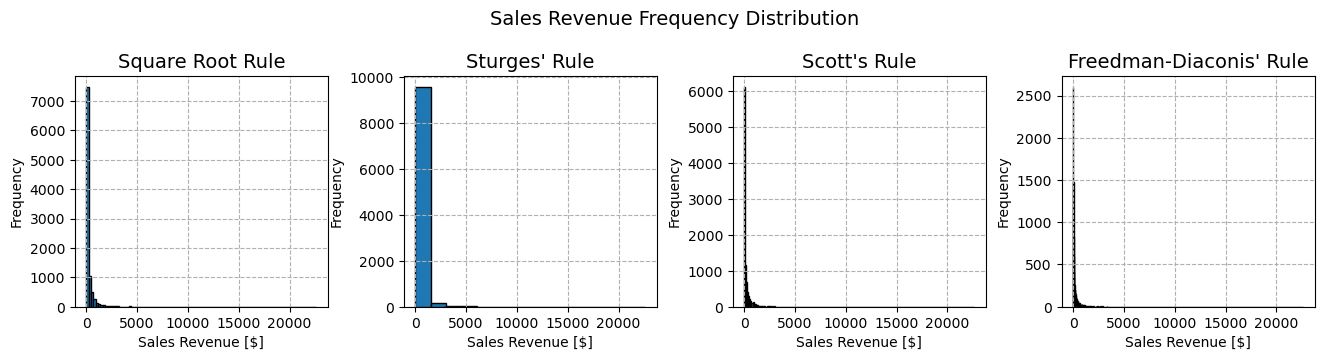

In [10]:
fig1, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

fig1.suptitle('Sales Revenue Frequency Distribution', y=1.1, fontsize=14)

ax[0].set_title('Square Root Rule', fontsize=14)
bins = int(np.sqrt(len(df_0)))
ax[0].hist(df_0.Sales, bins=bins, color='C0', edgecolor='black')

ax[1].set_title("Sturges' Rule", fontsize=14)
bins = int(np.ceil(np.log2(len(df_0)) + 1))
ax[1].hist(df_0.Sales, bins=bins, color='C0', edgecolor='black')

ax[2].set_title("Scott's Rule", fontsize=14)
bin_width = int(3.5 * np.std(df_0.Sales) / len(df_0) ** (1 / 3))
bins = range(int(min(df_0.Sales)), int(max(df_0.Sales)) + bin_width, bin_width)
ax[2].hist(df_0.Sales, bins=bins, color='C0', edgecolor='black')

ax[3].set_title("Freedman-Diaconis' Rule", fontsize=14)
iqr = np.percentile(df_0.Sales, 75) - np.percentile(df_0.Sales, 25)
bin_width = 2 * iqr / len(df_0) ** (1 / 3)
bins = int((max(df_0.Sales) - min(df_0.Sales)) / bin_width)
ax[3].hist(df_0.Sales, bins=bins, color='C0', edgecolor='black')

for x in range(4):
    ax[x].set(xlabel='Sales Revenue [$]', ylabel='Frequency')
    ax[x].grid(ls='--')

plt.show()

The Sales' distribution is highly left-skewed. We note the presence of few entries with high sales revenue, as seen more easily in the following plot.

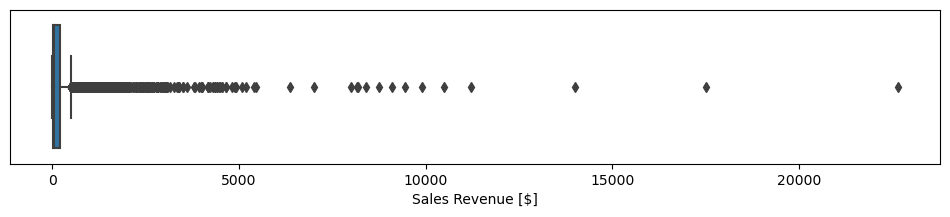

In [11]:
fig2, ax = plt.subplots(figsize = (12,2))

sns.boxplot(df_0.Sales, orient='h', ax=ax)

ax.set(xlabel='Sales Revenue [$]', ylabel='')
ax.set_yticks([])
ax.set_yticklabels([])

plt.show()

Before starting the time series analysis, the Sales' distribution left-skeweness and the presence of the highest revenue sales need to be taken care of.

<a id='select'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Feature Selection and Transformation  <span style="float:right;"> 2. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In [12]:
# Creating a copy of the dataset

df_1 = df_0.copy()

In [13]:
selected_features = ['Order Date', 'City', 'State', 'Region', 'Category', 
                     'Sub-Category','Product ID', 'Product Name', 'Sales']

df_1 = df_1[selected_features]

In [14]:
# Convert dates from object type to pandas datetime format

df_1['Order Date'] = pd.to_datetime(df_1['Order Date'], format='%d/%m/%Y')

# Sorting data by 'Order Date'

df_1.sort_values(by=['Order Date'], inplace=True, ascending=True)

# Setting 'Order Date' as the index

df_1.set_index('Order Date', inplace = True)

In [15]:
# Rounding the sales to 2 decimals, as they are listed with 3 decimals.

df_1['Sales'] = df_1['Sales'].round(2)

In [16]:
df_1.head(2)

,City,State,Region,Category,Sub-Category,Product ID,Product Name,Sales
Order Date,,,,,,,,
2015-01-03,Houston,Texas,Central,Office Supplies,Paper,OFF-PA-10000174,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.45
2015-01-04,Naperville,Illinois,Central,Office Supplies,Binders,OFF-BI-10004094,GBC Standard Plastic Binding Systems Combs,3.54


In [17]:
# Checking time spanned by the dataset

print('Earliest sale registered:', df_1.index.min())
print('Latest sale registered:', df_1.index.max())

Earliest sale registered: 2015-01-03 00:00:00
Latest sale registered: 2018-12-30 00:00:00


The dataset spans 4 years, from January 2015 to December 2018.

Let's check if there are any dates without sales listed.

In [18]:
full_date_range = pd.date_range(start=df_1.index.min(), end=df_1.index.max())

missing_dates = full_date_range[~full_date_range.isin(df_1.index)]

print('Number of missing dates:', len(missing_dates))

Number of missing dates: 228


Before starting the time series analysis, the missing dates need to be taken care of.

<a id='eda'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Exploratory Data Analysis  <span style="float:right;"> 3. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

In this section I study how the sales are distributed in the different Regions, States, Cities, product' category and sub-category. It is therefore a summary of how the supermarket performed in the time span of the dataset. 

For this reason I do not remove or transform the highest revenue sales seen before in Fig 2, and for lack of other info, I consider them real sales. 

The missing dates are considered as dates with no sales, i.e. revenue equal to zero.

Let's see now how the sales are destributed in the different Regions.

In [19]:
regions = df_1.Region.unique().tolist()
regions

['Central', 'East', 'South', 'West']

In [20]:
tot_sales_count = df_1.shape[0]
tot_sales = round(df_1.Sales.sum(), 2)

value_counts_reg = df_1.groupby('Region')['Sales'].count().tolist()
tot_sales_reg = df_1.groupby('Region')['Sales'].sum().tolist()

value_counts_reg_perc = list(np.asarray(value_counts_reg)/tot_sales_count*100)
tot_sales_reg_perc = list(np.asarray(tot_sales_reg)/tot_sales*100)

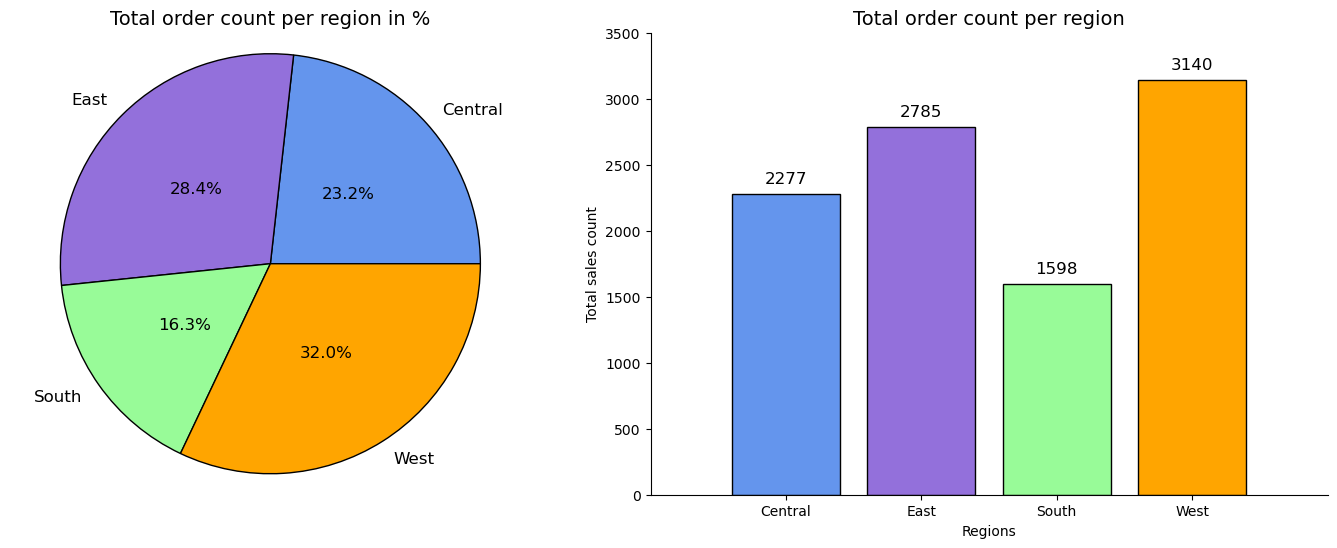

In [21]:
fig3, ax = plt.subplots(1, 2, figsize = (17,6), gridspec_kw={'width_ratios': [1, 1.3]})
plt.subplots_adjust(wspace=0.2)

colors_4 = ['cornflowerblue', 'mediumpurple', 'palegreen', 'orange']

ax[0].set_title('Total order count per region in %', fontsize=14)
ax[0].pie(value_counts_reg_perc, labels = regions, colors = colors_4,
       autopct = '%1.1f%%', pctdistance=0.5, labeldistance=1.1, textprops={'fontsize': 12},
       wedgeprops=dict(edgecolor='black')) 
ax[0].axis('equal')

xtick_location = [1,2,3,4]
ax[1].set_title('Total order count per region', fontsize=14)
ax[1].bar(xtick_location, value_counts_reg, color=colors_4, width=0.8, edgecolor='black', linewidth=1)
ax[1].set(xlabel='Regions', ylabel='Total sales count')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].axis([0,5,0,3500])
ax[1].set_xticks(xtick_location)
ax[1].set_xticklabels(regions)
for x in range(len(regions)):
    ax[1].text(xtick_location[x], value_counts_reg[x]+80, str(value_counts_reg[x]),
                   fontsize=12, horizontalalignment='center')

plt.show()

We note that the Regions with the highest order count are in descending order: West, East, Central, and South, with the West region having double the orders of the South region.

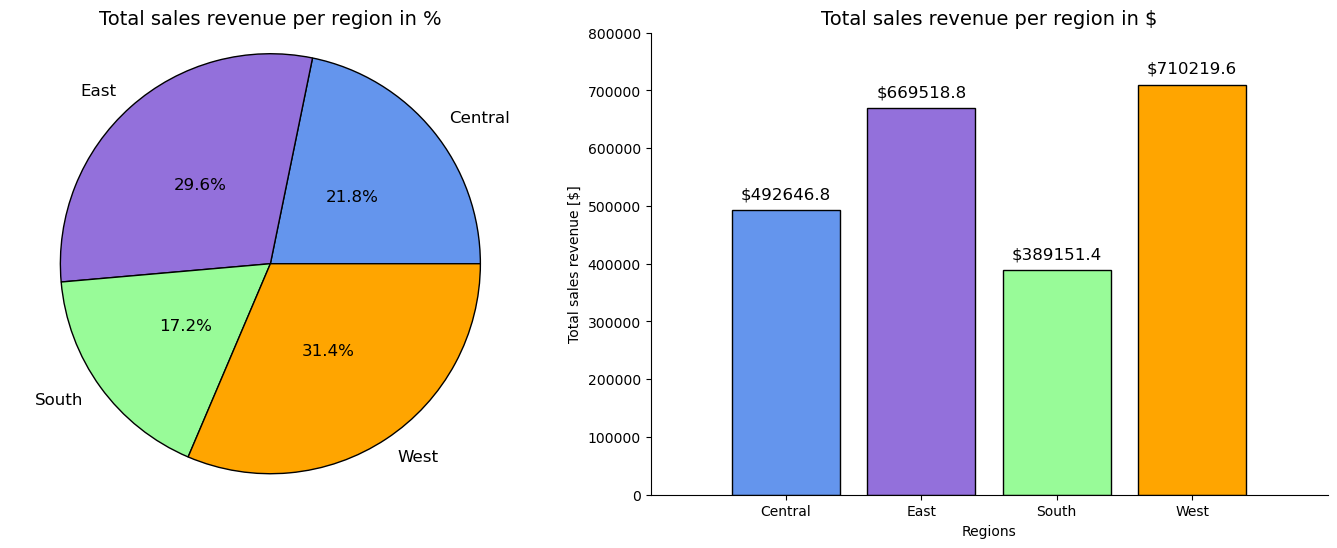

In [22]:
fig4, ax = plt.subplots(1, 2, figsize = (17,6), gridspec_kw={'width_ratios': [1, 1.3]})
plt.subplots_adjust(wspace=0.2)

ax[0].set_title('Total sales revenue per region in %', fontsize=14)
ax[0].pie(tot_sales_reg_perc, labels = regions, colors = colors_4,
       autopct = '%1.1f%%', pctdistance=0.5, labeldistance=1.1, textprops={'fontsize': 12},
       wedgeprops=dict(edgecolor='k'))
ax[0].axis('equal') 

ax[1].set_title('Total sales revenue per region in $', fontsize=14)
ax[1].bar(xtick_location, tot_sales_reg, color=colors_4, width=0.8, edgecolor='k', linewidth=1)
ax[1].set(xlabel='Regions', ylabel='Total sales revenue [$]')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].axis([0,5,0,800000])
ax[1].set_xticks(xtick_location)
ax[1].set_xticklabels(regions)
for x in range(len(regions)):
    ax[1].text(xtick_location[x], tot_sales_reg[x]+20000,'$'+ str(round(tot_sales_reg[x], 1)),
                   fontsize=12, horizontalalignment='center')

plt.show()

Regarding the sales revenue, the same behaviour is seen.

Let's see now the top 10 States that generated the highest revenues.

In [23]:
top_states_count = df_1.groupby(['State', 'Region'])[['Sales']].count().sort_values('Sales', ascending=False).head(10)
top_states_sales = df_1.groupby(['State', 'Region'])[['Sales']].sum('Sales').sort_values('Sales', ascending=False).head(10)

top_states_count['Sales_Count_Percentage'] = top_states_count.Sales/tot_sales_count*100
top_states_sales['Sales_Percentage'] = top_states_sales.Sales/tot_sales*100

top_states_count.reset_index(inplace=True)
top_states_sales.reset_index(inplace=True)

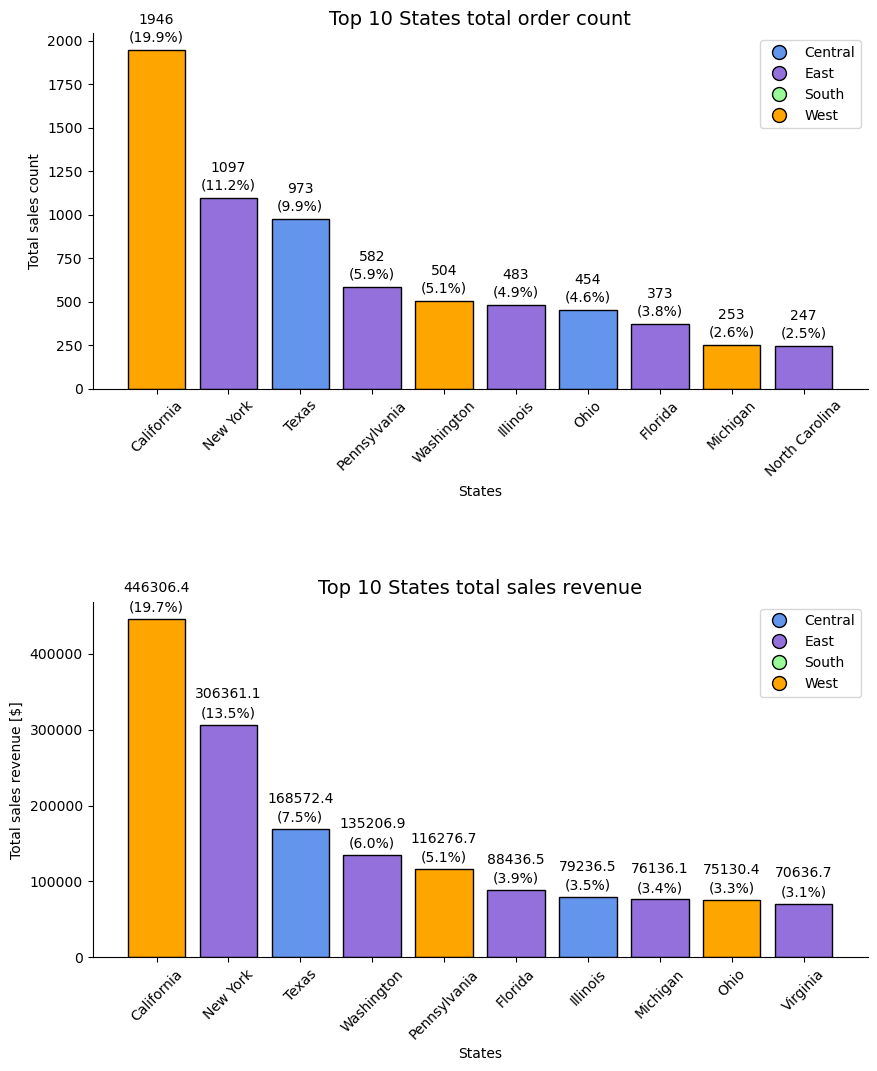

In [24]:
fig5, ax = plt.subplots(2, 1, figsize = (10,12))
plt.subplots_adjust(hspace=0.6)

reg_colors = []
for x in range(4):
    if top_states_count.loc[x, 'Region'] == regions[0]:
        reg_colors.append(colors_4[0])
    elif top_states_count.loc[x, 'Region'] == regions[1]:
        reg_colors.append(colors_4[1])
    elif top_states_count.loc[x, 'Region'] == regions[2]:
        reg_colors.append(colors_4[2])
    else:
        reg_colors.append(colors_4[3])

ax[0].set_title('Top 10 States total order count', fontsize=14)
ax[0].bar(top_states_count.State, top_states_count.Sales, width=0.8, edgecolor='k', linewidth=1, color=reg_colors)
ax[0].set(xlabel='States', ylabel='Total sales count')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params('x', labelrotation=45)
for x in range(10):
    ax[0].text(top_states_count.loc[x, 'State'], top_states_count.loc[x, 'Sales']+150,
               str(top_states_count.loc[x, 'Sales']), fontsize=10, horizontalalignment='center')
    ax[0].text(top_states_count.loc[x, 'State'], top_states_count.loc[x, 'Sales']+50,
               '('+str(round(top_states_count.loc[x, 'Sales_Count_Percentage'],1))+'%)', fontsize=10, horizontalalignment='center')
    
dummy_handles = [plt.Line2D([0], [0], marker='o', c='w', mfc=color, mec='k', markersize=10) for color in colors_4]
ax[0].legend(dummy_handles, regions)

ax[1].legend(dummy_handles, regions)
ax[1].set_title('Top 10 States total sales revenue', fontsize=14)
ax[1].bar(top_states_sales.State, top_states_sales.Sales, width=0.8, edgecolor='k', linewidth=1, color=reg_colors)
ax[1].set(xlabel='States', ylabel='Total sales revenue [$]')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params('x', labelrotation=45)
for x in range(10):
    ax[1].text(top_states_sales.loc[x, 'State'], top_states_sales.loc[x, 'Sales']+35000,
               str(round(top_states_sales.loc[x, 'Sales'], 1)), fontsize=10, horizontalalignment='center')
    ax[1].text(top_states_sales.loc[x, 'State'], top_states_sales.loc[x, 'Sales']+10000,
               '('+str(round(top_states_sales.loc[x, 'Sales_Percentage'],1))+'%)', fontsize=10, horizontalalignment='center')

    
plt.show()

California, New York, and Texas are, in descending order, the States with the higher order count and sales revenue. California accounts for the 20% of the total shop orders and sales revenue. We note that no States of the South region are in the top 10 States.

Let's see now the top 10 Cities that generated the highest revenues.

In [25]:
top_cities_count = df_1.groupby(['City', 'Region'])[['Sales']].count().sort_values('Sales', ascending=False).head(10)
top_cities_sales = df_1.groupby(['City', 'Region'])[['Sales']].sum('Sales').sort_values('Sales', ascending=False).head(10)

top_cities_count['Sales_Count_Percentage'] = top_cities_count.Sales/tot_sales_count*100
top_cities_sales['Sales_Percentage'] = top_cities_sales.Sales/tot_sales*100

top_cities_count.reset_index(inplace=True)
top_cities_sales.reset_index(inplace=True)

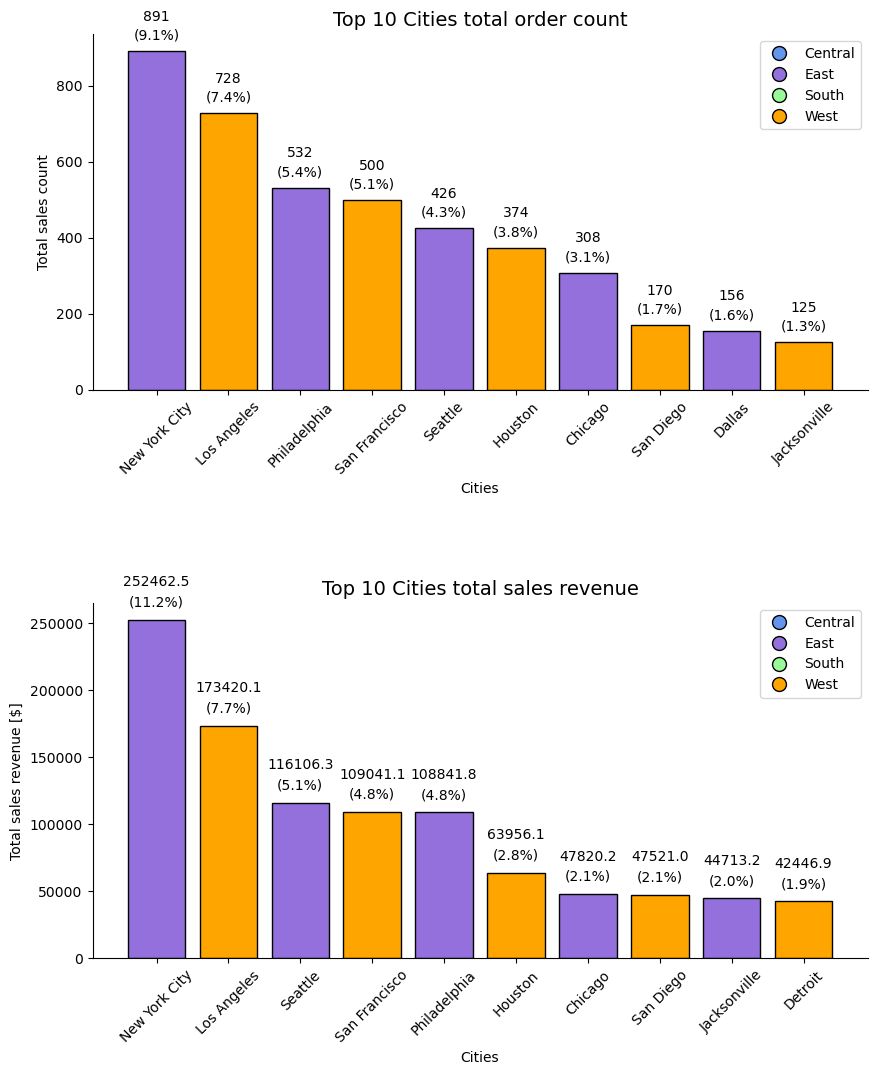

In [26]:
fig6, ax = plt.subplots(2, 1, figsize = (10,12))
plt.subplots_adjust(hspace=0.6)

reg_colors = []
for x in range(4):
    if top_cities_count.loc[x, 'Region'] == regions[0]:
        reg_colors.append(colors_4[0])
    elif top_cities_count.loc[x, 'Region'] == regions[1]:
        reg_colors.append(colors_4[1])
    elif top_cities_count.loc[x, 'Region'] == regions[2]:
        reg_colors.append(colors_4[2])
    else:
        reg_colors.append(colors_4[3])

ax[0].set_title('Top 10 Cities total order count', fontsize=14)
ax[0].bar(top_cities_count.City, top_cities_count.Sales, width=0.8, edgecolor='k', linewidth=1, color=reg_colors)
ax[0].set(xlabel='Cities', ylabel='Total sales count')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params('x', labelrotation=45)
for x in range(10):
    ax[0].text(top_cities_count.loc[x, 'City'], top_cities_count.loc[x, 'Sales']+80,
               str(top_cities_count.loc[x, 'Sales']), fontsize=10, horizontalalignment='center')
    ax[0].text(top_cities_count.loc[x, 'City'], top_cities_count.loc[x, 'Sales']+30,
               '('+str(round(top_cities_count.loc[x, 'Sales_Count_Percentage'],1))+'%)', fontsize=10, horizontalalignment='center')

dummy_handles = [plt.Line2D([0], [0], marker='o', c='w', mfc=color, mec='k', markersize=10) for color in colors_4]
ax[0].legend(dummy_handles, regions)    

ax[1].legend(dummy_handles, regions) 
ax[1].set_title('Top 10 Cities total sales revenue', fontsize=14)
ax[1].bar(top_cities_sales.City, top_cities_sales.Sales, width=0.8, edgecolor='k', linewidth=1, color=reg_colors)
ax[1].set(xlabel='Cities', ylabel='Total sales revenue [$]')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params('x', labelrotation=45)
for x in range(10):
    ax[1].text(top_cities_sales.loc[x, 'City'], top_cities_sales.loc[x, 'Sales']+25000,
               str(round(top_cities_sales.loc[x, 'Sales'], 1)), fontsize=10, horizontalalignment='center')
    ax[1].text(top_cities_sales.loc[x, 'City'], top_cities_sales.loc[x, 'Sales']+10000,
               '('+str(round(top_cities_sales.loc[x, 'Sales_Percentage'],1))+'%)', fontsize=10, horizontalalignment='center')

    
plt.show()

New York City and Los Angeles are the most important cities in terms of orders and sales revenue. No Cities of the Central and South Regions are present here.

Let's see now how the sales are destributed in the different products' Category and Sub-Category.

In [27]:
category_count = df_1.groupby(['Category'])[['Sales']].count().sort_values('Sales', ascending=False)
category_sales = df_1.groupby(['Category'])[['Sales']].sum('Sales').sort_values('Sales', ascending=False)

category_count['Sales_Count_Percentage'] = category_count.Sales/tot_sales_count*100
category_sales['Sales_Percentage'] = category_sales.Sales/tot_sales*100

category_count.reset_index(inplace=True)
category_sales.reset_index(inplace=True)

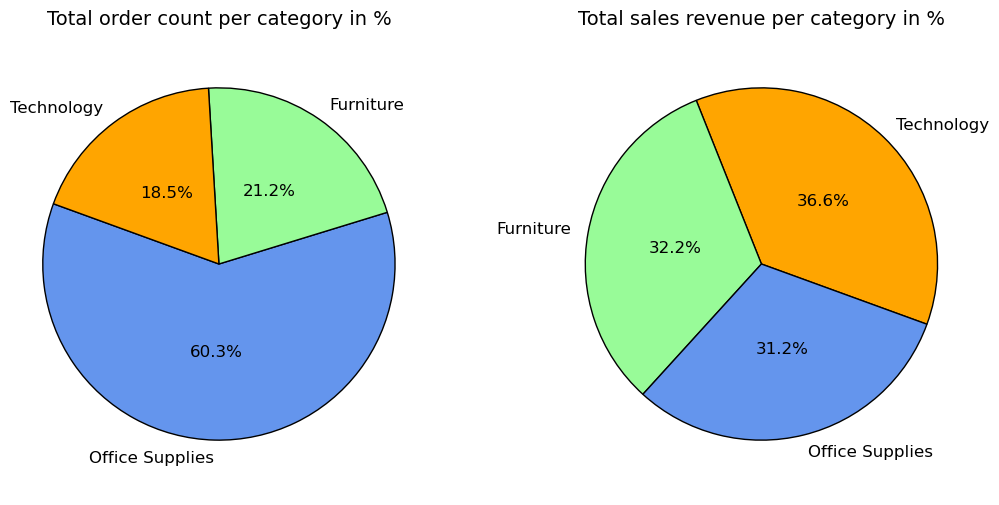

In [28]:
fig7, ax = plt.subplots(1, 2, figsize = (12,6))
plt.subplots_adjust(wspace=0.4)

colors_3 = ['cornflowerblue', 'palegreen', 'orange']
ax[0].set_title('Total order count per category in %', fontsize=14)
ax[0].pie(category_count['Sales_Count_Percentage'], labels = category_count['Category'], colors = colors_3,
       autopct = '%1.1f%%', pctdistance=0.5, labeldistance=1.1, textprops={'fontsize': 12},
       wedgeprops=dict(edgecolor='black'), startangle = 160)
ax[0].axis('equal') 

colors_3 = ['orange', 'palegreen', 'cornflowerblue']
ax[1].set_title('Total sales revenue per category in %', fontsize=14)
ax[1].pie(category_sales['Sales_Percentage'], labels = category_sales['Category'], colors = colors_3,
       autopct = '%1.1f%%', pctdistance=0.5, labeldistance=1.1, textprops={'fontsize': 12},
       wedgeprops=dict(edgecolor='black'), startangle = -20)
ax[1].axis('equal') 

plt.show()

While the office supplies category dominates the orders count, it does not dominate the sales revenue. All three category share similar sales revenue, with the technology one being higher by ~5%.

Let's check now the top 10 sub-categories.

In [29]:
top_subcategory_count = df_1.groupby(['Category','Sub-Category'])[['Sales']].count().sort_values('Sales', ascending=False).head(10)
top_subcategory_sales = df_1.groupby(['Category','Sub-Category'])[['Sales']].sum('Sales').sort_values('Sales', ascending=False).head(10)

top_subcategory_count['Sales_Count_Percentage'] = top_subcategory_count.Sales/tot_sales_count*100
top_subcategory_sales['Sales_Percentage'] = top_subcategory_sales.Sales/tot_sales*100

top_subcategory_count.reset_index(inplace=True)
top_subcategory_sales.reset_index(inplace=True)

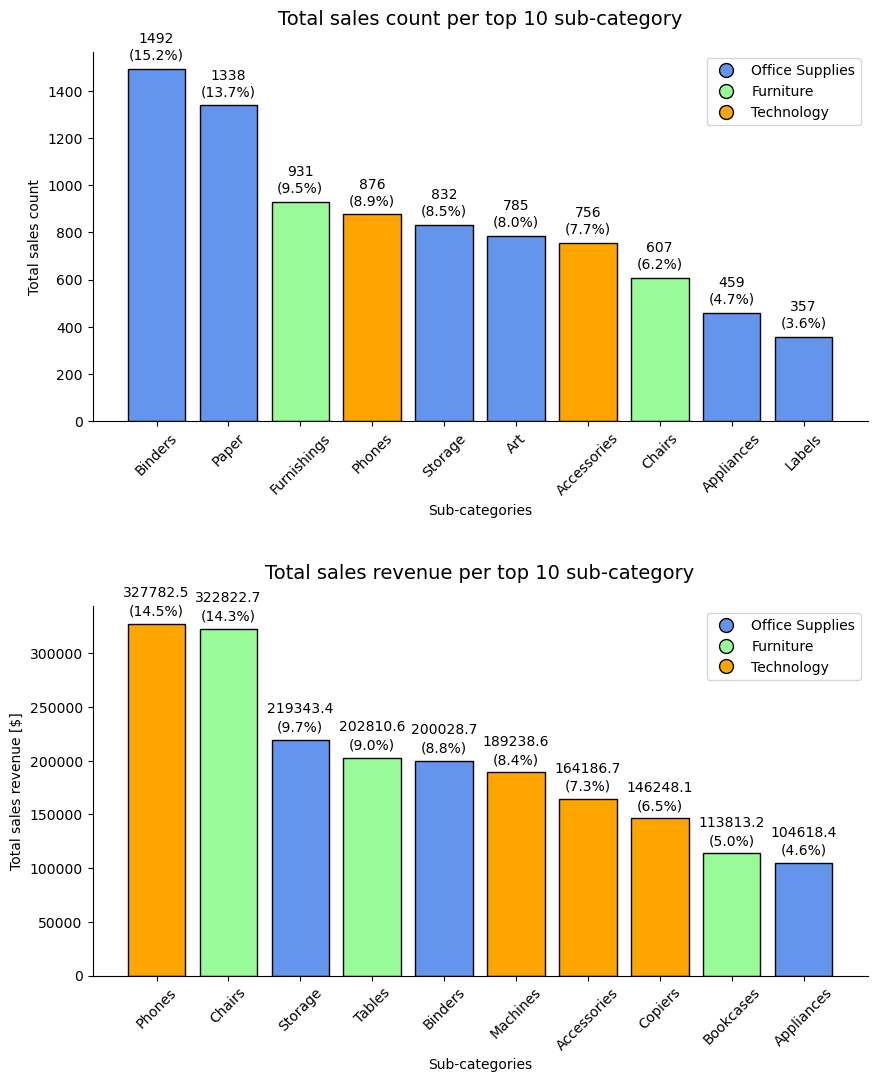

In [30]:
fig8, ax = plt.subplots(2, 1, figsize = (10,12))
plt.subplots_adjust(hspace=0.5)

colors_3 = ['cornflowerblue', 'palegreen', 'orange']
category_labels = top_subcategory_count.Category.unique()
cat_colors = []
for x in range(10):
    if top_subcategory_count.loc[x, 'Category'] == category_labels[0]:
        cat_colors.append(colors_3[0])
    elif top_subcategory_count.loc[x, 'Category'] == category_labels[1]:
        cat_colors.append(colors_3[1])
    else:
        cat_colors.append(colors_3[2])

ax[0].set_title("Total sales count per top 10 sub-category", fontsize=14, y=1.05)
ax[0].bar(top_subcategory_count['Sub-Category'], top_subcategory_count['Sales'], 
          width=0.8, edgecolor='k', linewidth=1, color = cat_colors)
ax[0].set(xlabel='Sub-categories', ylabel='Total sales count')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].tick_params('x', labelrotation=45)
for x in range(10):
    ax[0].text(top_subcategory_count.loc[x, 'Sub-Category'], top_subcategory_count.loc[x, 'Sales']+110,
               str(top_subcategory_count.loc[x, 'Sales']), fontsize=10, horizontalalignment='center')
    ax[0].text(top_subcategory_count.loc[x, 'Sub-Category'], top_subcategory_count.loc[x, 'Sales']+40,
               '('+str(round(top_subcategory_count.loc[x, 'Sales_Count_Percentage'],1))+'%)', 
               fontsize=10, horizontalalignment='center')
    
dummy_handles = [plt.Line2D([0], [0], marker='o', c='w', mfc=color, mec='k', markersize=10) for color in colors_3]
ax[0].legend(dummy_handles, category_labels)

cat_colors = []
for x in range(10):
    if top_subcategory_sales.loc[x, 'Category'] == category_labels[0]:
        cat_colors.append(colors_3[0])
    elif top_subcategory_sales.loc[x, 'Category'] == category_labels[1]:
        cat_colors.append(colors_3[1])
    else:
        cat_colors.append(colors_3[2])

ax[1].set_title("Total sales revenue per top 10 sub-category", fontsize=14, y=1.05)
ax[1].bar(top_subcategory_sales['Sub-Category'], top_subcategory_sales['Sales'], 
          width=0.8, edgecolor='k', linewidth=1, color = cat_colors)
ax[1].set(xlabel='Sub-categories', ylabel='Total sales revenue [$]')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params('x', labelrotation=45)
for x in range(10):
    ax[1].text(top_subcategory_sales.loc[x, 'Sub-Category'], top_subcategory_sales.loc[x, 'Sales']+25000,
               str(round(top_subcategory_sales.loc[x, 'Sales'], 1)), fontsize=10, horizontalalignment='center')
    ax[1].text(top_subcategory_sales.loc[x, 'Sub-Category'], top_subcategory_sales.loc[x, 'Sales']+8000,
               '('+str(round(top_subcategory_sales.loc[x, 'Sales_Percentage'],1))+'%)', 
               fontsize=10, horizontalalignment='center')
    
ax[1].legend(dummy_handles, category_labels)

plt.show()

Blinders and paper dominate the order count, but not the sales revenue, which is dominated by the phones and chairs sales.

Let's check now the products with the highest sales revenue.

In [31]:
top_product_sales = df_1.groupby(['Product ID', 'Product Name', 'Category'])[['Sales']].sum('Sales').sort_values('Sales', ascending=False).head(10)

top_product_sales['Sales_Percentage'] = top_product_sales.Sales/tot_sales*100

top_product_sales.reset_index(inplace=True)

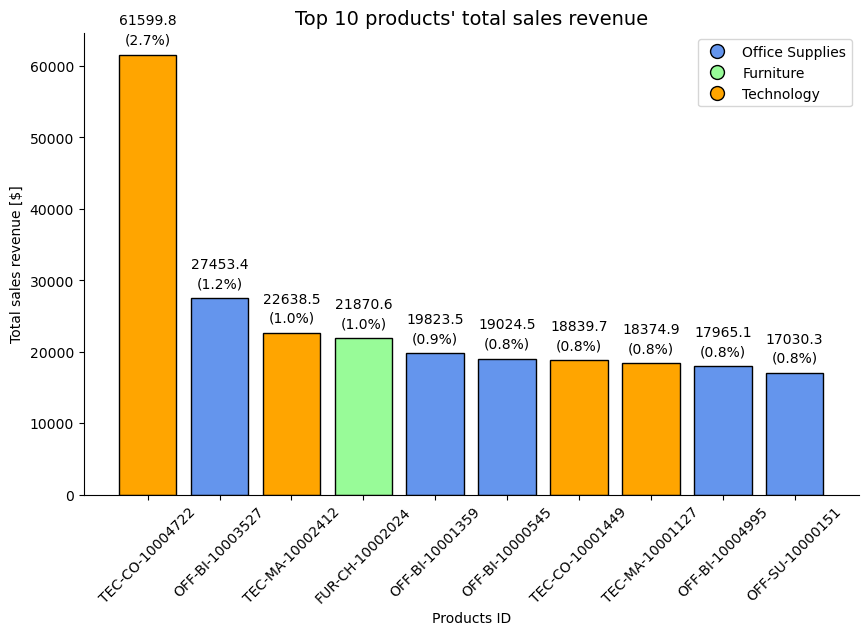

In [32]:
fig9, ax = plt.subplots(figsize = (10,6))

cat_colors = []
for x in range(10):
    if top_product_sales.loc[x, 'Category'] == category_labels[0]:
        cat_colors.append(colors_3[0])
    elif top_product_sales.loc[x, 'Category'] == category_labels[1]:
        cat_colors.append(colors_3[1])
    else:
        cat_colors.append(colors_3[2])
    
ax.set_title("Top 10 products' total sales revenue", fontsize=14)
ax.bar(top_product_sales['Product ID'], top_product_sales['Sales'], width=0.8, edgecolor='k', linewidth=1, color = cat_colors)
ax.set(xlabel='Products ID', ylabel='Total sales revenue [$]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params('x', labelrotation=45)
for x in range(10):
    ax.text(top_product_sales.loc[x, 'Product ID'], top_product_sales.loc[x, 'Sales']+4200,
               str(round(top_product_sales.loc[x, 'Sales'], 1)), fontsize=10, horizontalalignment='center')
    ax.text(top_product_sales.loc[x, 'Product ID'], top_product_sales.loc[x, 'Sales']+1500,
               '('+str(round(top_product_sales.loc[x, 'Sales_Percentage'],1))+'%)', 
               fontsize=10, horizontalalignment='center')
    
dummy_handles = [plt.Line2D([0], [0], marker='o', c='w', mfc=color, mec='k', markersize=10) for color in colors_3]
ax.legend(dummy_handles, category_labels)

plt.show()

In [33]:
top_product_sales.head(10)

,Product ID,Product Name,Category,Sales,Sales_Percentage
0,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,61599.83,2.723804
1,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,Office Supplies,27453.38,1.213926
2,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,Technology,22638.48,1.001022
3,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,Furniture,21870.57,0.967067
4,OFF-BI-10001359,GBC DocuBind TL300 Electric Binding System,Office Supplies,19823.47,0.876549
5,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,Office Supplies,19024.50,0.841220
6,TEC-CO-10001449,Hewlett Packard LaserJet 3310 Copier,Technology,18839.68,0.833048
7,TEC-MA-10001127,HP Designjet T520 Inkjet Large Format Printer ...,Technology,18374.89,0.812496
8,OFF-BI-10004995,GBC DocuBind P400 Electric Binding System,Office Supplies,17965.07,0.794375
9,OFF-SU-10000151,High Speed Automatic Electric Letter Opener,Office Supplies,17030.31,0.753042


The Canon imageCLASS 2200 Advanced Copier is the item with the highest sales revenue.

Finally, let's see the total (all entries of the dataset) sales revenue over the years.

In [34]:
df_daily_sales = df_1[['Sales']].groupby(df_1.index).sum()

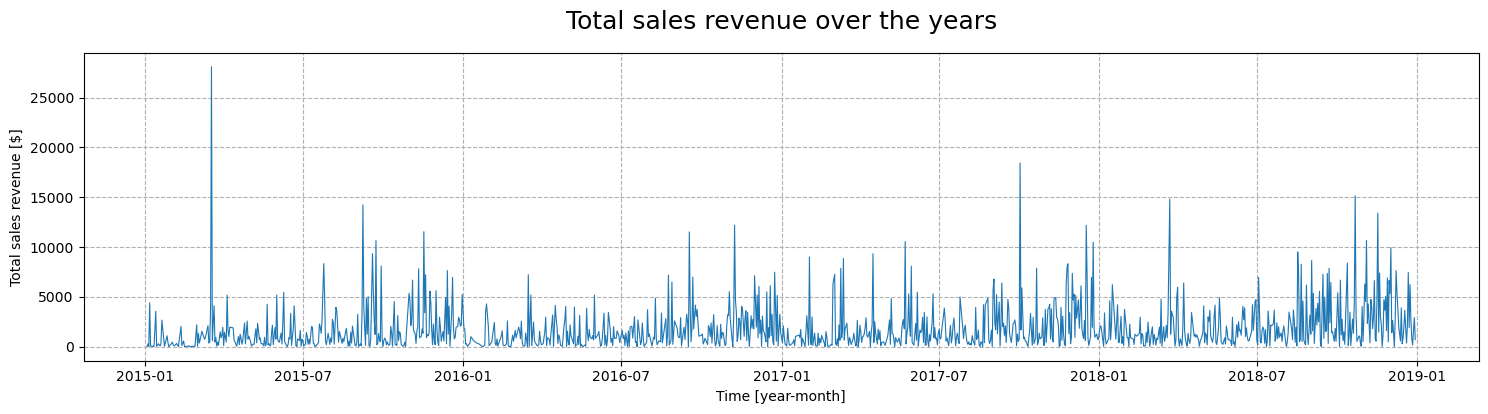

In [35]:
fig10, ax = plt.subplots(figsize = (18,4))

ax.set_title('Total sales revenue over the years', y=1.05, fontsize=18)

ax.plot(df_daily_sales.index, df_daily_sales.Sales, lw=0.8)

ax.set(xlabel='Time [year-month]', ylabel='Total sales revenue [$]')
ax.grid(ls='--')

plt.show()

The sales data plotted as a function of time are chaotic due to the different daily sales revenues.

At a first look, it seems that the revenue is fluctuating with a constant trend in time.

Let's see if the monthly and yearly sales revenue help us.

In [36]:
df_monthly_sales = df_daily_sales.resample('M').sum()

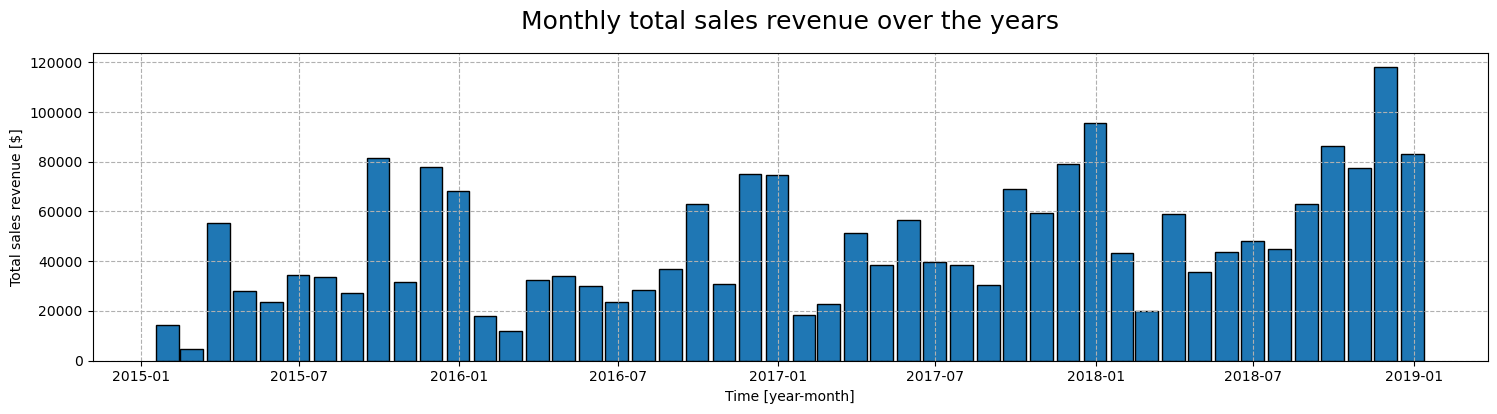

In [37]:
fig11, ax = plt.subplots(figsize = (18,4))

ax.set_title('Monthly total sales revenue over the years', y=1.05, fontsize=18)

ax.bar(df_monthly_sales.index, df_monthly_sales.Sales, width=26, edgecolor='k')

ax.set(xlabel='Time [year-month]', ylabel='Total sales revenue [$]')
ax.grid(ls='--')

plt.show()

In [38]:
df_yearly_sales = df_daily_sales.resample('Y').sum()

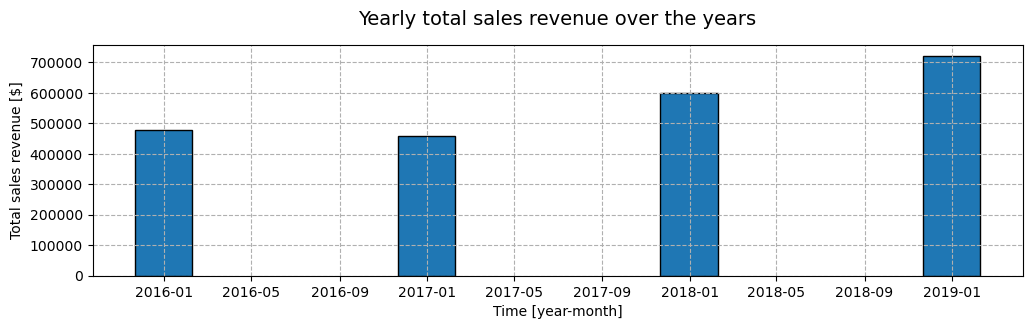

In [39]:
fig12, ax = plt.subplots(figsize = (12,3))

ax.set_title('Yearly total sales revenue over the years', y=1.05, fontsize=14)

ax.bar(df_yearly_sales.index, df_yearly_sales.Sales, width=80, edgecolor='k')
ax.set(xlabel='Time [year-month]', ylabel='Total sales revenue [$]')

ax.grid(ls='--')

plt.show()

In [40]:
print('Variation of sales revenue in % from 01.01.2016 to 01.01.2017: ', round((df_yearly_sales.Sales.iloc[1] - df_yearly_sales.Sales.iloc[0]) / df_yearly_sales.Sales.iloc[0] *100, 2),'\n')
print('Variation of sales revenue in % from 01.01.2017 to 01.01.2018: ', round((df_yearly_sales.Sales.iloc[2] - df_yearly_sales.Sales.iloc[1]) / df_yearly_sales.Sales.iloc[1] *100, 2),'\n')
print('Variation of sales revenue in % from 01.01.2018 to 01.01.2019: ', round((df_yearly_sales.Sales.iloc[3] - df_yearly_sales.Sales.iloc[2]) / df_yearly_sales.Sales.iloc[2] *100, 2),'\n')
print('Total variation of sales revenue in % from 01.01.2016 to 01.01.2019:', round((df_yearly_sales.Sales.iloc[3] - df_yearly_sales.Sales.iloc[0]) / df_yearly_sales.Sales.iloc[0] *100, 2))

Variation of sales revenue in % from 01.01.2016 to 01.01.2017:  -4.26 

Variation of sales revenue in % from 01.01.2017 to 01.01.2018:  30.64 

Variation of sales revenue in % from 01.01.2018 to 01.01.2019:  20.3 

Total variation of sales revenue in % from 01.01.2016 to 01.01.2019: 50.47


Exept for a small drop in sales between 01.01.2016 and 01.01.2017, the shop sales have increased in revenue yearly.

With respect to sales revenue of the first year, after 3 years the revenue has increased by 50.5%.

<a id='time'></a>
# <div style='color:b; background-color:w; text-align:left; font-size:100%; font-family:Arial; margin-top: 75px;'> Time Series Analysis  <span style="float:right;"> 4. </span> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;"> </div>

We are going to analyze the sales revenue over the years of all the products, for all the cities, regions, and states, and for all the categories and sub-categories combined. The goal is to understand the underlying patterns in the data and 
to forecast future sales.

The first step is to fill the missing days in the dataset. Different techniques can be used to handle the missing values, like forward/backward filling, interpolation, or mean/median imputation.

Let's use a time-based interpolation.

In [41]:
# Creating new df containing the missing days with their interpolated sales value

df_daily_interp = df_daily_sales.resample('1D').interpolate(method='time')

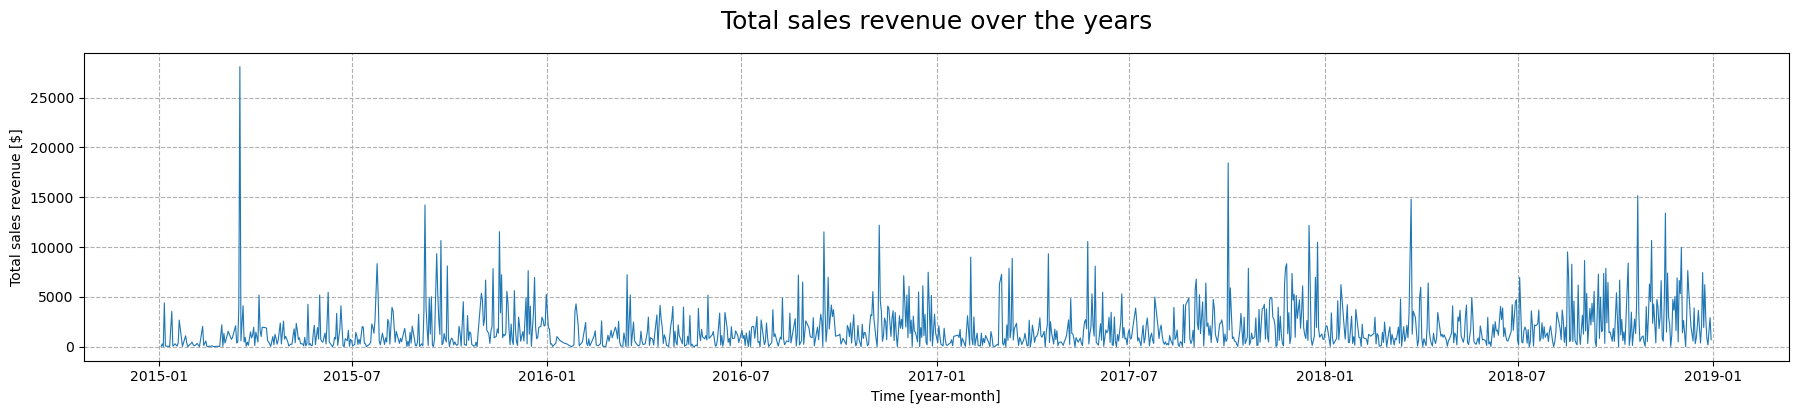

In [42]:
fig13, ax = plt.subplots(figsize = (22,4))

ax.set_title('Total sales revenue over the years', y=1.05, fontsize=18)

ax.plot(df_daily_interp.index, df_daily_interp.Sales, lw=0.8)
ax.set(xlabel='Time [year-month]', ylabel='Total sales revenue [$]')

ax.grid(ls='--')

plt.show()

The next step is to deal with the left-skewed distribution of the sales, and the presence of the outliers.

Let's apply some transformations to the sales data to make their distribution more normal.

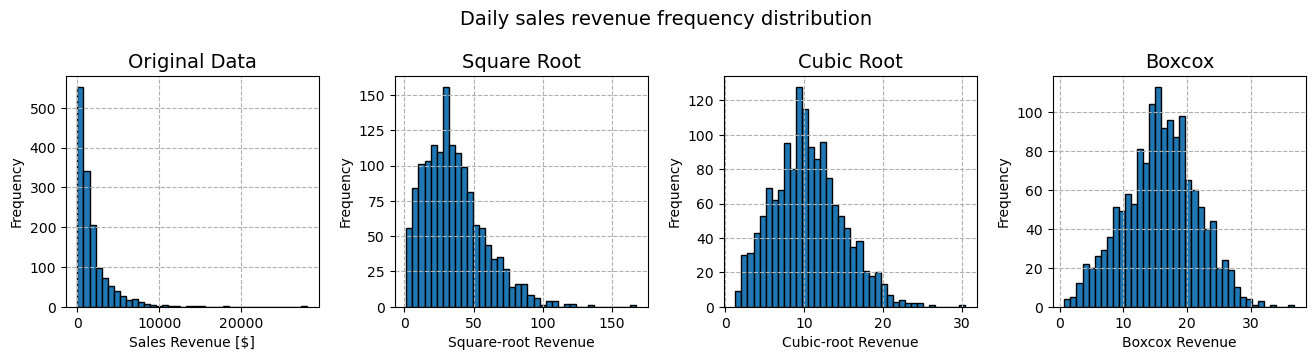

In [43]:
fig14, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

fig14.suptitle('Daily sales revenue frequency distribution', y=1.1, fontsize=14)

bins = int(np.sqrt(len(df_daily_interp)))

ax[0].set_title('Original Data', fontsize=14)
ax[0].hist(df_daily_interp.Sales, bins=bins, color='C0', edgecolor='black')
ax[0].set(xlabel='Sales Revenue [$]', ylabel='Frequency')

ax[1].set_title("Square Root", fontsize=14)
ax[1].hist(np.sqrt(df_daily_interp.Sales), bins=bins, color='C0', edgecolor='black')
ax[1].set(xlabel='Square-root Revenue', ylabel='Frequency')

ax[2].set_title("Cubic Root", fontsize=14)
ax[2].hist(np.cbrt(df_daily_interp.Sales), bins=bins, color='C0', edgecolor='black')
ax[2].set(xlabel='Cubic-root Revenue', ylabel='Frequency')

df_daily_interp['Sales_boxcox'], lambda_value_day = boxcox(df_daily_interp.Sales)
ax[3].set_title("Boxcox", fontsize=14)
ax[3].hist(df_daily_interp['Sales_boxcox'], bins=bins, color='C0', edgecolor='black')
ax[3].set(xlabel='Boxcox Revenue', ylabel='Frequency')

for x in range(4):
    ax[x].grid(ls='--')
     
plt.show()

We note that a normal distribution is best achieved using a boxcox transformation.

From now on, we will work with these data.

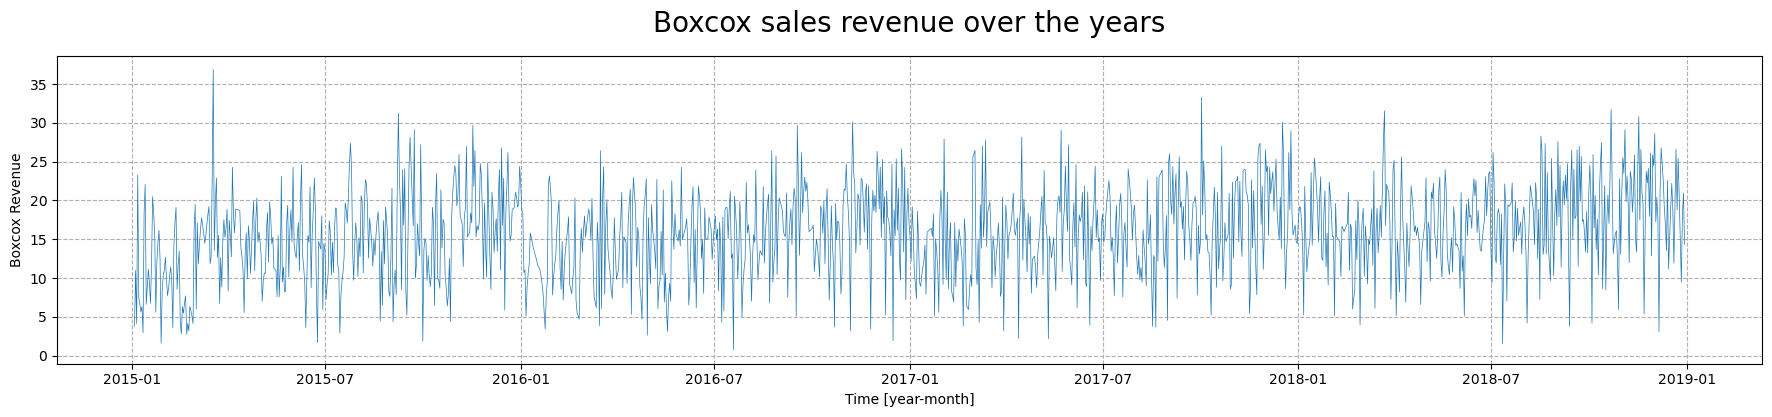

In [44]:
fig15, ax = plt.subplots(figsize = (22,4))

ax.set_title('Boxcox sales revenue over the years', y=1.05, fontsize=20)

ax.plot(df_daily_interp.index, df_daily_interp['Sales_boxcox'], lw=0.5)

ax.set(xlabel='Time [year-month]', ylabel='Boxcox Revenue')
ax.grid(ls='--')

plt.show()

SARIMA models, a class of linear models that utilizes historical values to forecast future values, require the dataset to be stationary and independent. Let's check if our dataset follows these assumptions by plotting the autocorrelation function (ACF).

The ACF plot is a common tool used in time series analysis to understand the correlation between a time series and its lagged values. In a stationary time series, autocorrelations at different lags are random and not significantly different from zero.

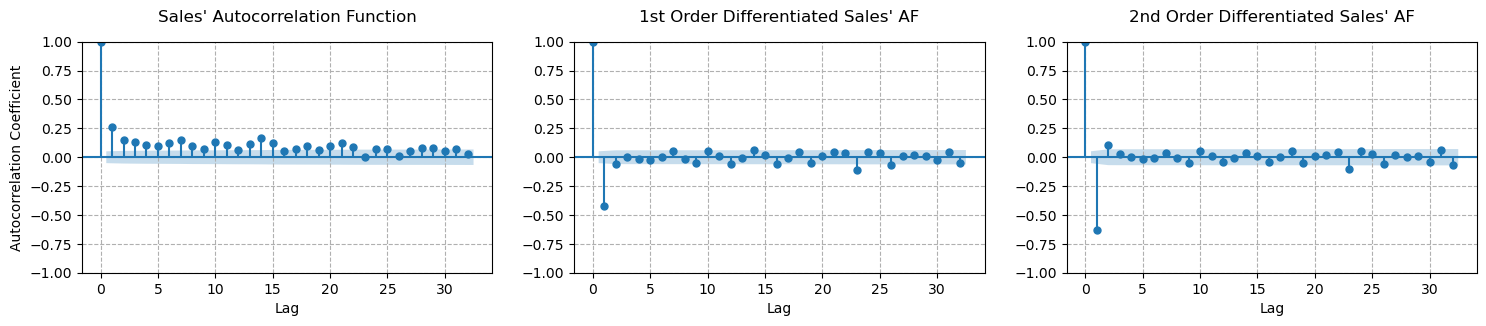

In [45]:
fig16, ax = plt.subplots(1, 3, figsize=(18,3))
plt.subplots_adjust(wspace=0.2)

plot_acf(df_daily_interp['Sales_boxcox'], ax=ax[0])
ax[0].set_title("Sales' Autocorrelation Function", y=1.05)

plot_acf(df_daily_interp['Sales_boxcox'].diff().dropna(), ax=ax[1])
ax[1].set_title("1st Order Differentiated Sales' AF", y=1.05)

plot_acf(df_daily_interp['Sales_boxcox'].diff().diff().dropna(), ax=ax[2])
ax[2].set_title("2nd Order Differentiated Sales' AF", y=1.05)

for x in range(3):
    ax[x].set(xlabel='Lag', ylabel='')
    ax[x].grid(ls='--')
    
ax[0].set(xlabel='Lag', ylabel='Autocorrelation Coefficient')

plt.show()

From the plots, we note that the dataset may require a first order differencing to be stationary. At the same time, the first lag in the 1st order differetiated sales AF is close to -0.5, meaning that we are potentially over-differenciating the dataset. 

Therefore, we are going to check for stationarity through the Augmented Dickey-Fuller (ADF) test. It is a statistical test used to determine whether a time series has a unit root, which is an indication of non-stationarity. The null hypothesis of the ADF test is that the time series has a unit root. The alternative hypothesis is that the series is stationary. If the ADF metric is close or smaller than the critical values and the ADF test p-value is less than 0.05 we can reject the null hypothesis and conclude that the time series is stationary.

In [46]:
dftest_d0 = adfuller(df_daily_interp['Sales_boxcox'], autolag='AIC')
dftest_d1 = adfuller(df_daily_interp['Sales_boxcox'].diff().dropna(), autolag='AIC')
dftest_d2 = adfuller(df_daily_interp['Sales_boxcox'].diff().diff().dropna(), autolag='AIC')

dftests = [dftest_d0, dftest_d1, dftest_d2]

for x in range(3):
    print('\nDifferencing parameter d =', x)
    print('\nADF metric = ', str(round(dftests[x][0],2)))
    print('ADF test p-value:', round(dftests[x][1], 25))
    print('Critical Values: ')
    for key, val in dftests[x][4].items():
        print(key,':',round(val, 2))


Differencing parameter d = 0

ADF metric =  -5.35
ADF test p-value: 4.359570004435425e-06
Critical Values: 
1% : -3.43
5% : -2.86
10% : -2.57

Differencing parameter d = 1

ADF metric =  -12.07
ADF test p-value: 2.3180000000000005e-22
Critical Values: 
1% : -3.43
5% : -2.86
10% : -2.57

Differencing parameter d = 2

ADF metric =  -16.81
ADF test p-value: 0.0
Critical Values: 
1% : -3.43
5% : -2.86
10% : -2.57


With the test results, we can reject the null hypothesis, i.e. there is evidence to suggest that the time series is stationary even without differencing.
Having checked that our data are stationary and independent, we can now create our SARIMA model.

The library pmdarima will help us in that by running a setpwise search in order to select the SARIMA parameters that minimize the Bayesian Information Criterion (BIC). It is a measure of the relative quality of a statistical model which penalizes models more heavily for complexity. Lower BIC values indicate a better trade-off between fit and complexity.

In [47]:
################################## WARNING! EXPENSIVE COMPUTATION! ################################################
## Stepwise search
#
#df_train = df_weekly_interp.iloc[:int(len(df_daily_interp['Sales_boxcox'])*0.8)]
#df_test = df_weekly_interp.iloc[int(len(df_daily_interp['Sales_boxcox'])*0.8):]
#
#seasonality_param = [7, 31, 183, 365]
#
#auto_models = []
#
#for m in seasonality_param:
#    step_model_i = pm.auto_arima(df_train, m=m, information_criterion='bic', trace=True, 
#                                 out_of_sample_size=len(df_daily_interp), max_order=None)
#    auto_models.append(step_model_i)
###################################################################################################################

Unfortunately, my laptop (i5-12500H, 16GB RAM) cannot handle pmdarima, as the cores temperature reach values higher than 90 degrees.

Therefore, we are going to follow a different approach and decompose our time series using LOESS into three components: Seasonal, Trend, and Residual. To do that, we need to input in statsmodels.tsa.seasonal.STL the periodicity of our data.

Let's try to estimate it visually. Let's plot our data with a weekly frequency.

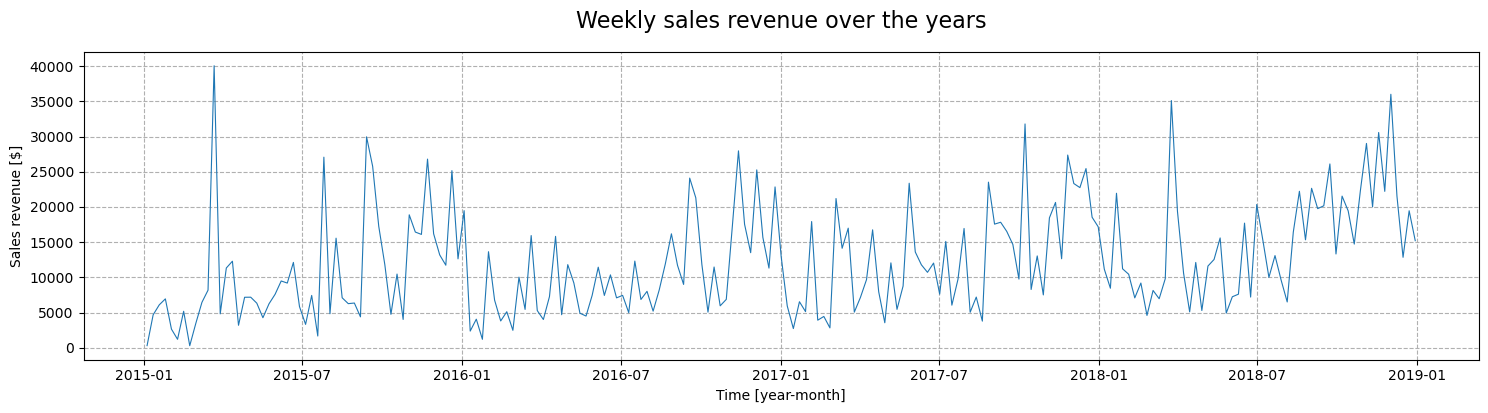

In [48]:
df_weekly_interp = df_daily_interp.resample('W').sum()

fig17, ax = plt.subplots(figsize = (18,4))

ax.set_title('Weekly sales revenue over the years', y=1.05, fontsize=16)

ax.plot(df_weekly_interp.index, df_weekly_interp['Sales'], lw=0.8)

ax.set(xlabel='Time [year-month]', ylabel='Sales revenue [$]')
ax.grid(ls='--')

plt.show()

The situation is still not clear. Let's plot our data with a monthly frequency.

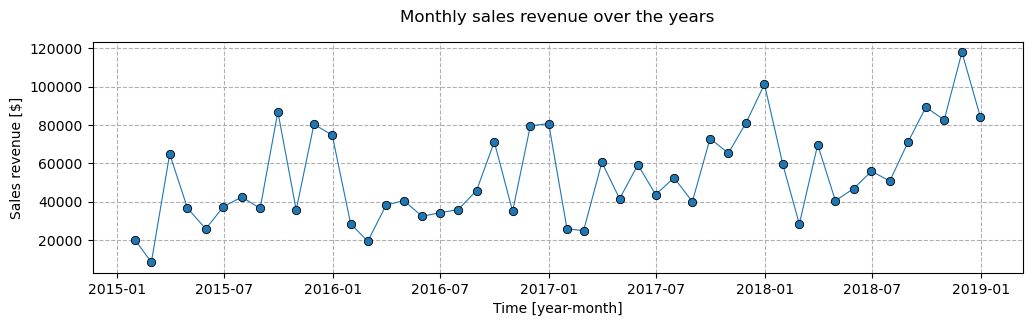

In [49]:
df_mothly_interp = df_daily_interp.resample('M').sum()

fig18, ax = plt.subplots(figsize = (12,3))

ax.set_title('Monthly sales revenue over the years', y=1.05, fontsize=12)

ax.plot(df_mothly_interp.index, df_mothly_interp['Sales'], lw=0.8, marker='o', mec='k', mew=0.6)

ax.set(xlabel='Time [year-month]', ylabel='Sales revenue [$]')
ax.grid(ls='--')

plt.show()

We note here that our data show a yearly seasonality. To have more reliable results, let's decompose our data through LOESS with different models accounting different seasonalities. We will then compare the models on the base of the Mean Absolute Percentage Error (MAPE) and R-squared (R2). 

MAPE expresses the average absolute percentage difference between the predicted values and the actual values. Therefore a lower value indicates a more accurate model.

R2 is a statistical measure of how well the decomposition captures the variability in the original data.
It ranges from 0 to 1. An R2 value closer to 1 indicates that a larger proportion of the variance in the dependent variable is explained by the model.

In [50]:
seasonalities = [7, 31, 90, 122, 183, 365]
seasonality_df = pd.DataFrame(columns=['period','mape','r2'])

for m in seasonalities:
    
    data_decomposed = STL(endog=df_daily_interp['Sales_boxcox'], period=m).fit()
    model = data_decomposed.trend + data_decomposed.seasonal
    
    mape = (abs(df_daily_interp['Sales_boxcox']-model)/(df_daily_interp['Sales_boxcox'])).mean()
    r2 = r2_score(df_daily_interp['Sales_boxcox'], model)
    
    new_row = {'period':round(m,2), 'mape':round(mape,2), 'r2': round(r2,4)}
    if seasonality_df.empty:
        seasonality_df = pd.DataFrame([new_row])
    else:
        seasonality_df = pd.concat([seasonality_df, pd.DataFrame([new_row])], ignore_index=True)
    
seasonality_df

,period,mape,r2
0,7,0.27,0.5850
1,31,0.31,0.4670
2,90,0.30,0.4882
3,122,0.32,0.4333
4,183,0.31,0.4432
5,365,0.23,0.6645


We note that the best model accounts for a yearly seasonality, as suggested by our visual inspection.
The model has a R2 value of 0.665, meaning that 66.5% of the total variance is explained by the model. The MAPE value indicates that the model's predictions deviate by 23% from the actual values.

Let's visualize the model and its components.

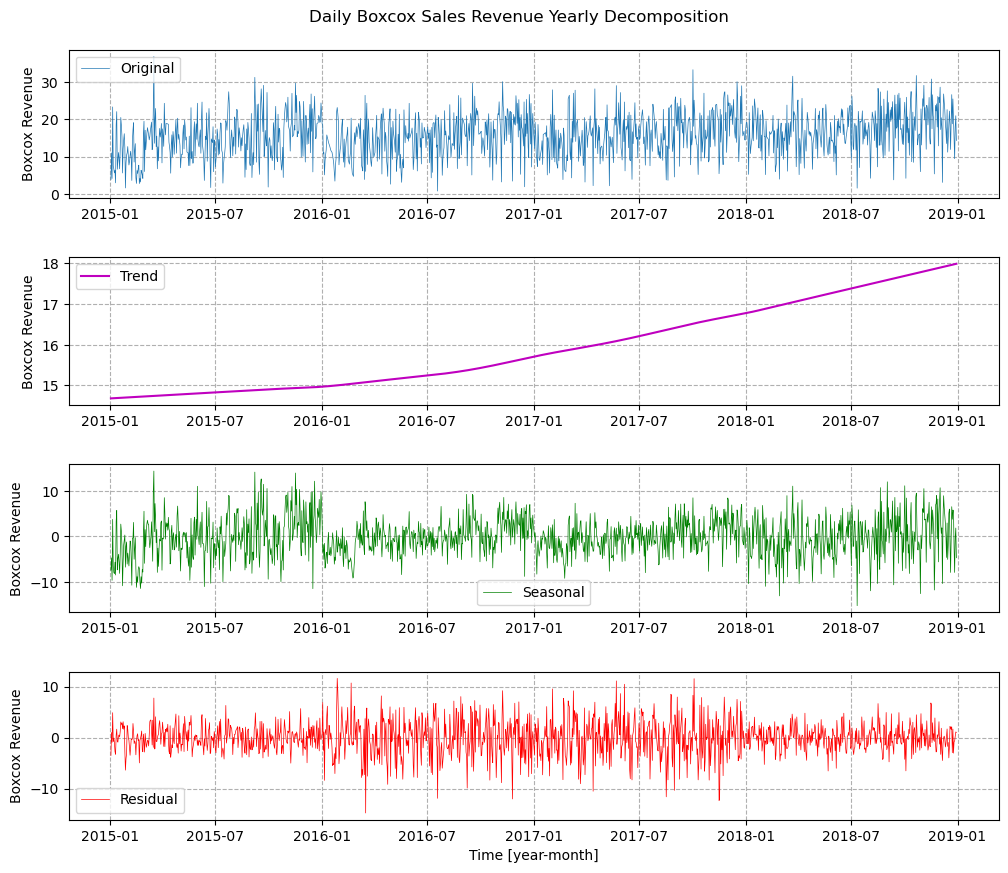

In [51]:
data_decomposed = STL(endog=df_daily_interp['Sales_boxcox'], period=365).fit()

fig19, ax = plt.subplots(4, 1, figsize=(12,10))
plt.subplots_adjust(hspace=0.4)

fig19.suptitle('Daily Boxcox Sales Revenue Yearly Decomposition', y=0.92)

ax[0].plot(df_daily_interp.index, df_daily_interp['Sales_boxcox'], lw=0.5, label='Original')
ax[1].plot(data_decomposed.trend, label='Trend', color='m')
ax[2].plot(data_decomposed.seasonal, lw=0.5, label='Seasonal', color='g')
ax[3].plot(data_decomposed.resid, lw=0.5, label='Residual', color='r')

ax[3].set_xlabel('Time [year-month]')
for x in range(4):
    ax[x].set_ylabel('Boxcox Revenue')
    ax[x].grid(ls='--')
    ax[x].legend()

We note an upwarding trend, already suggested in Fig. 12.

We note from the seasonal and residuals component, that the seasonal one does not capture effectively the daily trend of the data. Let's try to simplify our dataset by studying the weekly sales revenue instead, and see if we can create a better model.

In [52]:
df_weekly_interp.drop('Sales_boxcox', axis=1, inplace=True)

df_weekly_interp['Sales_squareroot'] = np.sqrt(df_weekly_interp.Sales)
df_weekly_interp['Sales_boxcox'], lambda_value_week = boxcox(df_weekly_interp.Sales)

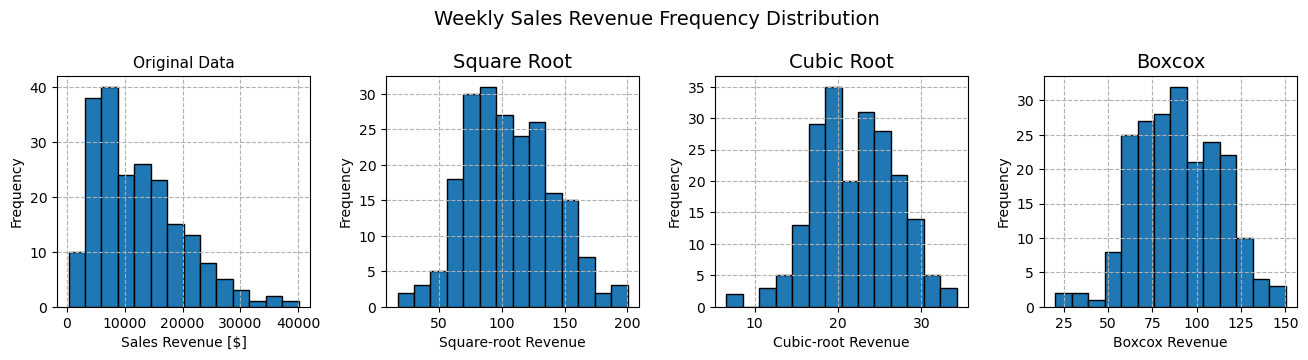

In [53]:
fig20, ax = plt.subplots(1, 4, figsize = (16,3))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

fig20.suptitle('Weekly Sales Revenue Frequency Distribution', y=1.1, fontsize=14)

bins = int(np.sqrt(len(df_weekly_interp)))

ax[0].set_title('Original Data', fontsize=11)
ax[0].hist(df_weekly_interp.Sales, bins=bins, color='C0', edgecolor='black')
ax[0].set(xlabel='Sales Revenue [$]', ylabel='Frequency')

ax[1].set_title("Square Root", fontsize=14)
ax[1].hist(np.sqrt(df_weekly_interp.Sales), bins=bins, color='C0', edgecolor='black')
ax[1].set(xlabel='Square-root Revenue', ylabel='Frequency')

ax[2].set_title("Cubic Root", fontsize=14)
ax[2].hist(np.cbrt(df_weekly_interp.Sales), bins=bins, color='C0', edgecolor='black')
ax[2].set(xlabel='Cubic-root Revenue', ylabel='Frequency')

ax[3].set_title("Boxcox", fontsize=14)
ax[3].hist(df_weekly_interp['Sales_boxcox'], bins=bins, color='C0', edgecolor='black')
ax[3].set(xlabel='Boxcox Revenue', ylabel='Frequency')

for x in range(4):
    ax[x].grid(ls='--')

plt.show()

The weekly sales distribution is also left-skewed. A square-root or boxcox transformation makes the distribution more symmetric.

In [54]:
dftest_d0 = adfuller(df_weekly_interp['Sales_squareroot'], autolag='AIC')
dftest_d1 = adfuller(df_weekly_interp['Sales_squareroot'].diff().dropna(), autolag='AIC')
dftest_d2 = adfuller(df_weekly_interp['Sales_squareroot'].diff().diff().dropna(), autolag='AIC')

dftests = [dftest_d0, dftest_d1, dftest_d2]

print('ADF test for Sales_squareroot')
for x in range(3):
    print('\nDifferencing parameter d =', x)
    print('\nADF = ', str(round(dftests[x][0],2)))
    print('ADF test p-value:', round(dftests[x][1], 25))
    print('Critical Values: ')
    for key, val in dftests[x][4].items():
        print(key,':',round(val, 2))

ADF test for Sales_squareroot

Differencing parameter d = 0

ADF =  -6.33
ADF test p-value: 2.992360030647019e-08
Critical Values: 
1% : -3.46
5% : -2.88
10% : -2.57

Differencing parameter d = 1

ADF =  -6.96
ADF test p-value: 9.399740626930216e-10
Critical Values: 
1% : -3.46
5% : -2.88
10% : -2.57

Differencing parameter d = 2

ADF =  -8.08
ADF test p-value: 1.4594613463613002e-12
Critical Values: 
1% : -3.47
5% : -2.88
10% : -2.57


In [55]:
dftest_d0 = adfuller(df_weekly_interp['Sales_boxcox'], autolag='AIC')
dftest_d1 = adfuller(df_weekly_interp['Sales_boxcox'].diff().dropna(), autolag='AIC')
dftest_d2 = adfuller(df_weekly_interp['Sales_boxcox'].diff().diff().dropna(), autolag='AIC')

dftests = [dftest_d0, dftest_d1, dftest_d2]

print('ADF test for Sales_boxcox')
for x in range(3):
    print('\nDifferencing parameter d =', x)
    print('\nADF = ', str(round(dftests[x][0],2)))
    print('ADF test p-value:', round(dftests[x][1], 25))
    print('Critical Values: ')
    for key, val in dftests[x][4].items():
        print(key,':',round(val, 2))

ADF test for Sales_boxcox

Differencing parameter d = 0

ADF =  -6.29
ADF test p-value: 3.634272954208722e-08
Critical Values: 
1% : -3.46
5% : -2.88
10% : -2.57

Differencing parameter d = 1

ADF =  -6.97
ADF test p-value: 8.771178604477196e-10
Critical Values: 
1% : -3.46
5% : -2.88
10% : -2.57

Differencing parameter d = 2

ADF =  -8.77
ADF test p-value: 2.4802124840900003e-14
Critical Values: 
1% : -3.46
5% : -2.88
10% : -2.57


The dataset is stationary, both for the square-root transformed values and the boxcox transformed ones.

Let's decompose the weekly square-root sales.

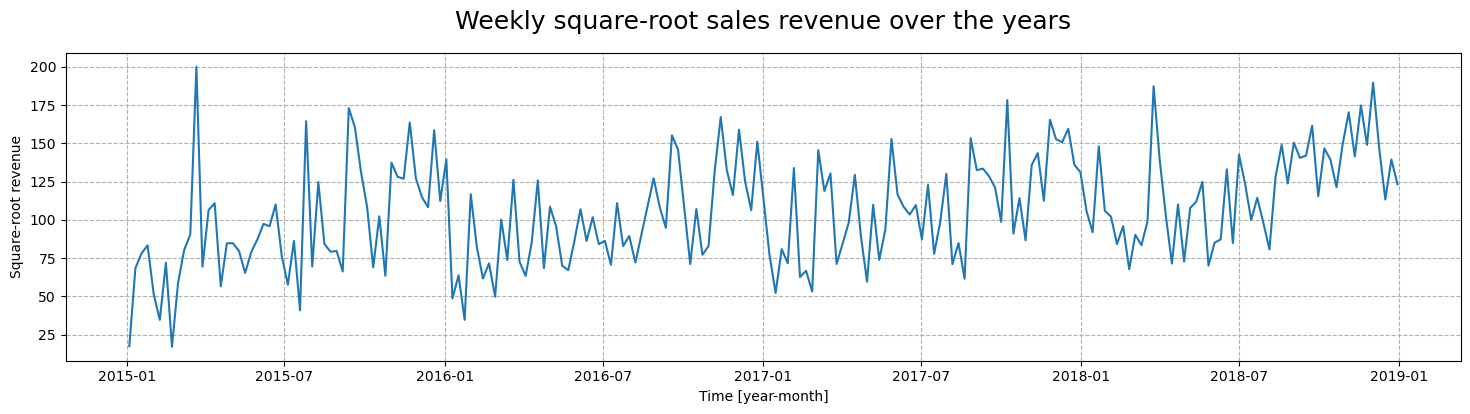

In [56]:
fig21, ax = plt.subplots(figsize = (18,4))

ax.set_title('Weekly square-root sales revenue over the years', y=1.05, fontsize=18)

ax.plot(df_weekly_interp.index, df_weekly_interp['Sales_squareroot'])

ax.set(xlabel='Time [year-month]', ylabel='Square-root revenue')
ax.grid(ls='--')

plt.show()

In [57]:
seasonalities = [4, 13, 17, 26, 52]
seasonality_df_week = pd.DataFrame(columns=['period','mape','r2'])

for m in seasonalities:
    
    data_decomposed = STL(endog=df_weekly_interp['Sales_squareroot'], period=m).fit()
    model = data_decomposed.trend + data_decomposed.seasonal
    
    mape = (abs(df_weekly_interp['Sales_squareroot'] - model)/(df_weekly_interp['Sales_squareroot'])).mean()
    r2 = r2_score(df_weekly_interp['Sales_squareroot'], model)
    
    new_row = {'period':round(m,2), 'mape':round(mape,4), 'r2': round(r2,4)}
    if seasonality_df_week.empty:
        seasonality_df_week = pd.DataFrame([new_row])
    else:
        seasonality_df_week = pd.concat([seasonality_df_week, pd.DataFrame([new_row])], ignore_index=True)
    
seasonality_df_week

,period,mape,r2
0,4,0.1701,0.7033
1,13,0.1732,0.6634
2,17,0.2061,0.5430
3,26,0.1919,0.6044
4,52,0.1382,0.7810


We note an improvement in both the MAPE (~ -9%) and in the R2 (~ +0.12) values.

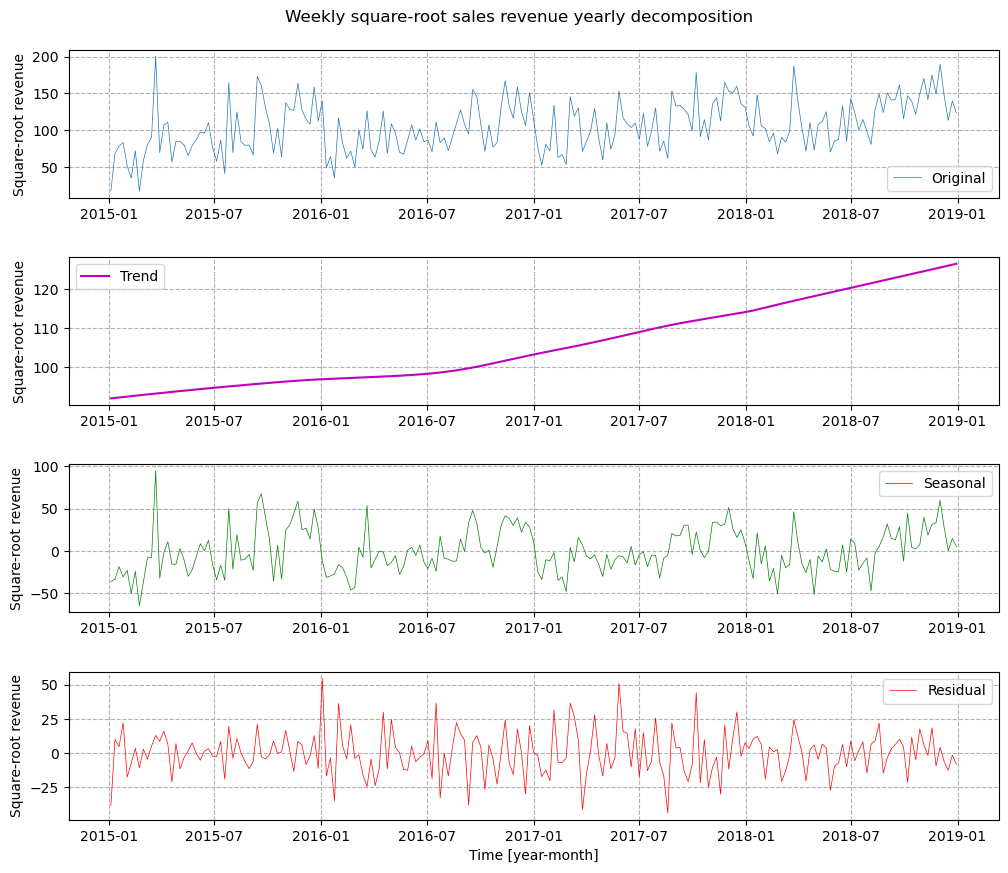

In [58]:
data_decomposed = STL(endog=df_weekly_interp['Sales_squareroot'], period=52).fit()

fig22, ax = plt.subplots(4, 1, figsize=(12,10))
plt.subplots_adjust(hspace=0.4)

fig22.suptitle('Weekly square-root sales revenue yearly decomposition', y=0.92)

ax[0].plot(df_weekly_interp.index, df_weekly_interp['Sales_squareroot'], lw=0.5, label='Original')
ax[1].plot(data_decomposed.trend, label='Trend', color='m')
ax[2].plot(data_decomposed.seasonal, lw=0.5, label='Seasonal', color='g')
ax[3].plot(data_decomposed.resid, lw=0.5, label='Residual', color='r')

ax[3].set_xlabel('Time [year-month]')
for x in range(4):
    ax[x].set_ylabel('Square-root revenue')
    ax[x].grid(ls='--')
    ax[x].legend()

Let's decompose now the weekly Boxcox sales.

In [59]:
seasonalities = [4, 13, 17, 26, 52]
seasonality_df_week = pd.DataFrame(columns=['period','mape','r2'])

for m in seasonalities:
    
    data_decomposed = STL(endog=df_weekly_interp['Sales_boxcox'], period=m).fit()
    model = data_decomposed.trend + data_decomposed.seasonal
    
    mape = (abs(df_weekly_interp['Sales_boxcox'] - model)/(df_weekly_interp['Sales_boxcox'])).mean()
    r2 = r2_score(df_weekly_interp['Sales_boxcox'], model)
    
    new_row = {'period':round(m,2), 'mape':round(mape,4), 'r2': round(r2,4)}
    if seasonality_df_week.empty:
        seasonality_df_week = pd.DataFrame([new_row])
    else:
        seasonality_df_week = pd.concat([seasonality_df_week, pd.DataFrame([new_row])], ignore_index=True)
    
seasonality_df_week

,period,mape,r2
0,4,0.1297,0.7054
1,13,0.1337,0.6685
2,17,0.1575,0.5454
3,26,0.1479,0.6094
4,52,0.1063,0.7806


We note an improvement in the MAPE (~ -3%) value and no improvement in the R2 one. Therefore, we will consider this model.

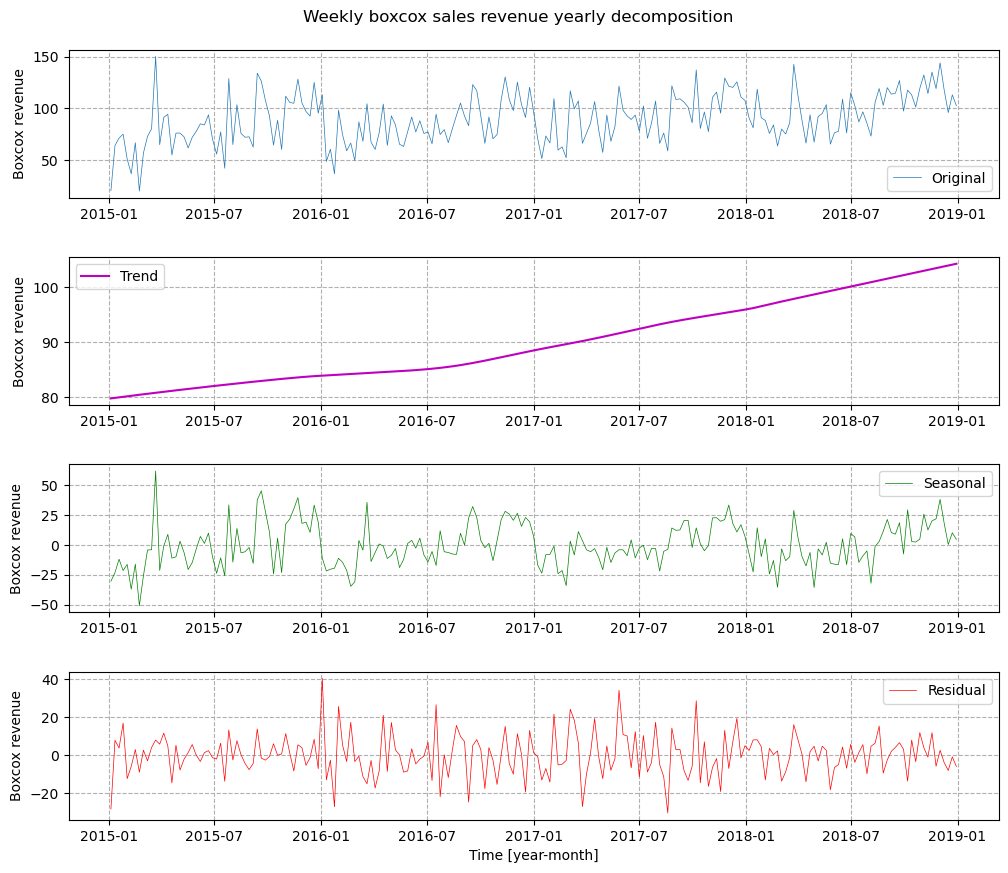

In [60]:
data_decomposed = STL(endog=df_weekly_interp['Sales_boxcox'], period=52).fit()

fig23, ax = plt.subplots(4, 1, figsize=(12,10))
plt.subplots_adjust(hspace=0.4)

fig23.suptitle('Weekly boxcox sales revenue yearly decomposition', y=0.92)

ax[0].plot(df_weekly_interp.index, df_weekly_interp['Sales_boxcox'], lw=0.5, label='Original')
ax[1].plot(data_decomposed.trend, label='Trend', color='m')
ax[2].plot(data_decomposed.seasonal, lw=0.5, label='Seasonal', color='g')
ax[3].plot(data_decomposed.resid, lw=0.5, label='Residual', color='r')

ax[3].set_xlabel('Time [year-month]')
for x in range(4):
    ax[x].set_ylabel('Boxcox revenue')
    ax[x].grid(ls='--')
    ax[x].legend()

Let's check if the distribution of the residuals of the model is normal. If the residuals are not normally distributed, it may indicate that the model is not capturing the underlying patterns in the data adequately. 

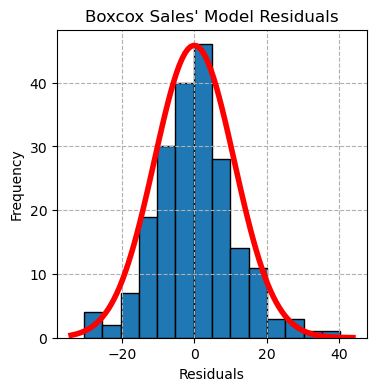

In [61]:
fig24, ax = plt.subplots(figsize=(4,4))

ax.set_title("Boxcox Sales' Model Residuals")

ax.hist(data_decomposed.resid, bins=int(np.sqrt(len(data_decomposed.resid))), color='C0', edgecolor='black')

# Fit a normal function to the residual component 
mu, std = norm.fit(data_decomposed.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, 1270*p, linewidth=4, color='r')

ax.set(xlabel='Residuals', ylabel='Frequency')
ax.grid(ls='--')

plt.show()

The distribution is fairly normal.

The last step is to forecast future sales values. Let's forecast sales in the next year.

In [62]:
future_periods = 52

trend, seasonal = data_decomposed.trend, data_decomposed.seasonal

future_index = pd.date_range(start=seasonal.index[-1], periods=future_periods + 1, freq='W')[1:]

forecasted_trend = trend.iloc[-1:] + trend.diff().mean()
forecasted_seasonal_values = seasonal.tail(52).values + seasonal.diff(52).mean()

forecasted_seasonal = pd.Series(forecasted_seasonal_values, index=future_index)

forecast_boxcox = forecasted_trend.values[0] + forecasted_seasonal

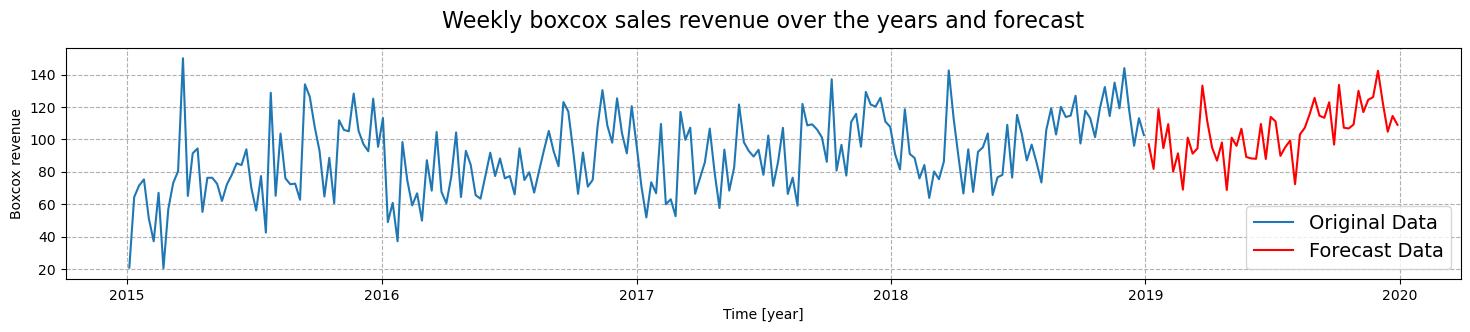

In [63]:
fig25, ax = plt.subplots(figsize=(18,3))

ax.set_title('Weekly boxcox sales revenue over the years and forecast', y=1.05, fontsize=16)

ax.plot(df_weekly_interp['Sales_boxcox'], label='Original Data')
ax.plot(forecast_boxcox, color='r', label='Forecast Data')

ax.set(xlabel='Time [year]', ylabel='Boxcox revenue')
ax.grid(ls='--')
ax.legend(fontsize=14)

plt.show()

Let's apply an inverse boxcox transformation to retrieve the correct sales values in dollar.

In [64]:
forecast = np.power((forecast_boxcox * lambda_value_week) + 1, 1 / lambda_value_week)

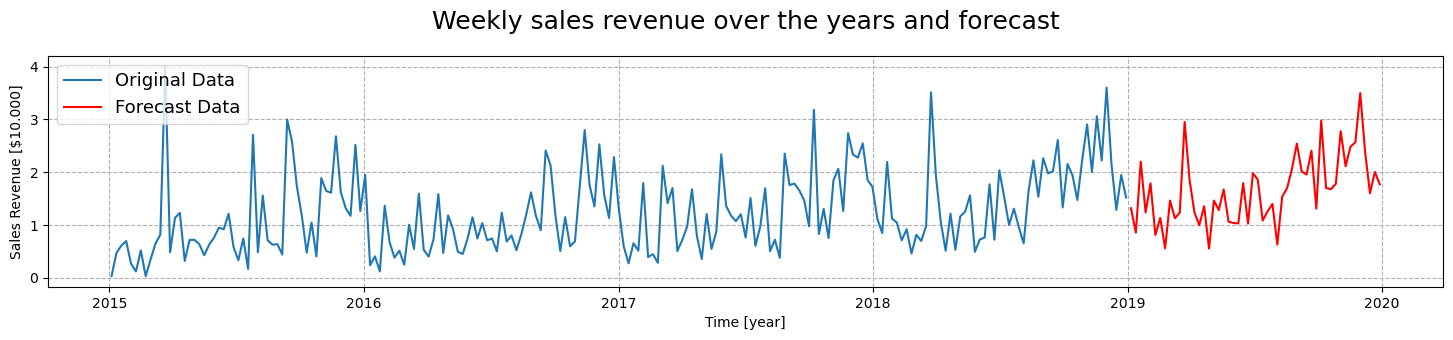

In [103]:
fig25, ax = plt.subplots(figsize=(18,3))

ax.set_title('Weekly sales revenue over the years and forecast', y=1.08, fontsize=18)

ax.plot(df_weekly_interp['Sales']/1e4, label='Original Data')
ax.plot(forecast/1e4, color='r', label='Forecast Data')

ax.set(xlabel='Time [year]', ylabel='Sales Revenue [$10.000]')
ax.grid(ls='--')
ax.legend(fontsize=13, loc=2)

plt.show()

In [105]:
fig25.savefig('Weekly_Sales_Forecast.jpg', dpi=250, bbox_inches='tight')

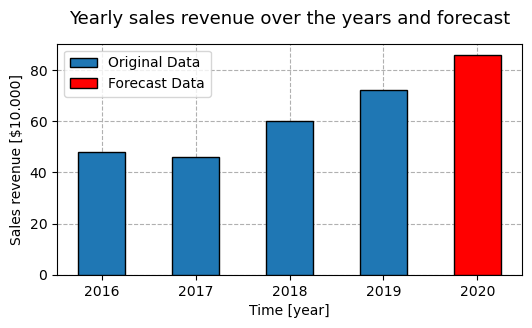

In [106]:
fig26, ax = plt.subplots(figsize = (6,3))

ax.set_title('Yearly sales revenue over the years and forecast', y=1.05, fontsize=13)

ax.bar([1,2,3,4], df_yearly_sales.Sales/1e4, width=0.5, label='Original Data', edgecolor='k', zorder=3)
ax.bar(5, forecast.sum()/1e4, width=0.5, label='Forecast Data', color='r', edgecolor='k', zorder=3)

ax.legend(fontsize=10)
ax.set(xlabel='Time [year]', ylabel='Sales revenue [$10.000]')
ax.grid(ls='--', zorder=0)

xtick_location = [1,2,3,4,5]
ax.set_xticks(xtick_location)
ax.set_xticklabels(['2016', '2017', '2018', '2019', '2020', ])

plt.show()

In [107]:
fig26.savefig('Yearly_Sales_Forecast.jpg', dpi=250, bbox_inches='tight')

In [68]:
print('Variation of sales revenue in % from 01.01.2016 to 01.01.2017: ', round((df_yearly_sales.Sales.iloc[1] - df_yearly_sales.Sales.iloc[0]) / df_yearly_sales.Sales.iloc[0] *100, 2),'\n')
print('Variation of sales revenue in % from 01.01.2017 to 01.01.2018: ', round((df_yearly_sales.Sales.iloc[2] - df_yearly_sales.Sales.iloc[1]) / df_yearly_sales.Sales.iloc[1] *100, 2),'\n')
print('Variation of sales revenue in % from 01.01.2018 to 01.01.2019: ', round((df_yearly_sales.Sales.iloc[3] - df_yearly_sales.Sales.iloc[2]) / df_yearly_sales.Sales.iloc[2] *100, 2),'\n')
print('Variation of sales revenue in % from 01.01.2019 to 01.01.2020: ', round((forecast.sum() - df_yearly_sales.Sales.iloc[3]) / df_yearly_sales.Sales.iloc[3] *100, 2))

Variation of sales revenue in % from 01.01.2016 to 01.01.2017:  -4.26 

Variation of sales revenue in % from 01.01.2017 to 01.01.2018:  30.64 

Variation of sales revenue in % from 01.01.2018 to 01.01.2019:  20.3 

Variation of sales revenue in % from 01.01.2019 to 01.01.2020:  19.19


The model suggests that in the year 2019 the sales revenue will be 19.2 +/- 10.6% larger than in the year 2018.

<a id='conclusion'></a>
# <div> <h1 style='font-family:Arial; font-size:100%; margin-top: 80px;'> Insights and Next Steps <span style="float:right;"> 5. </span> </h1> </div> <div> <hr style="border-top: 2px solid black; margin-top: 5px; margin-bottom: 0px;">


Key insights:

1. The West and East Regions had the highest sales revenue (~ \\$710.000 and ~ \\$670.000). Follow the Central (~ \\$490.000) and the South Region (~ \\$390.000)
2. California was the State accounting for the highest percentage of the total revenue (~ 20%). Follow New York (~ 13%) and Texas (~ 7%).
3. New York City (~ 11%) and Los Angeles (~ 8%) distinctly accounted for the highest percentage of the total revenue.
4. While the office supply category dominated the order count (~ 60% of the total orders), the technology category had the highest percentage of the total revenue (~ 36%). Office supply and furniture shared a similar total revenue percentage (~ 32%).
5. The phones and chairs sub-categories distinctly accounted for the highest percentage of the total revenue (~ 14%).
6. The Canon imageCLASS 2200 Advanced Copier was the item with the highest sales revenue (~ 3% of the total revenue).
7. Except for a small drop in sales between 01.01.2016 and 01.01.2017, the sales increased in revenue yearly. With respect to the sales revenue of 2015, after 3 years the revenue increased by 50.5%.
8. The sales revenue shows a yearly seasonality, peaking between the months of October and January.
9. The model created by decomposing the weekly sales revenue through LOESS, can explain 78.1% of the sales total variance (R2 = 0.781). The model's predictions deviate on average by 10.6% from the actual values (MAPE = 10.6%).
10. The model forecasts that in 2019 the sales revenue will be 19.2 +/- 10.6% larger than the ones in 2018.


Next steps:

1. Retrieve information about the number of citizien and average income in the different Regions, States, and Cities to understand better the relationship between sales and location.
2. Create a more complex model with SARIMA to try to improve the MAPE and R2 metrics.